<a href="https://colab.research.google.com/github/dannyycwang/LTL-based-Customer-Behavior-Prediction/blob/main/PCS955experiment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd

# 讀取資料
data = pd.read_csv(r'/content/drive/MyDrive/data/browsing_train.csv')

# 定義行為編碼對照
mapping = {
    'pageview': 1,
    ('event_product', 'detail'): 2,
    ('event_product', 'add'): 3,
    ('event_product', 'remove'): 4,
    ('event_product', 'purchase'): 5
}

# 將事件轉為行為代碼
def map_behavior(row):
    if row['event_type'] == 'pageview':
        return 1
    return mapping.get((row['event_type'], row['product_action']), 0)

data['behavior_code'] = data.apply(map_behavior, axis=1)

# 只保留時間欄位的右側7位數
data['server_timestamp_epoch_ms'] = data['server_timestamp_epoch_ms'] % 10_000_000

# 找出包含 purchase 的 session_id_hash
purchase_sessions = data[data['behavior_code'] == 5]['session_id_hash'].unique()

# 正樣本：只保留包含 purchase 的 session
positive_data = data[data['session_id_hash'].isin(purchase_sessions)]

# 負樣本：不包含 purchase 的 session
all_sessions = set(data['session_id_hash'].unique())
negative_sessions = list(all_sessions - set(purchase_sessions))
sampled_neg_sessions = pd.Series(negative_sessions).sample(n=4 * len(purchase_sessions), random_state=42)
negative_data = data[data['session_id_hash'].isin(sampled_neg_sessions)]

# 合併資料
filtered_data = pd.concat([positive_data, negative_data], axis=0)

# 聚合每個 session 的序列與價格
aggregated_data = filtered_data.groupby('session_id_hash').apply(lambda group: pd.Series({
    'behavior_sequence': group.sort_values('server_timestamp_epoch_ms')['behavior_code'].tolist(),
    'server_timestamp_epoch_ms': group.sort_values('server_timestamp_epoch_ms')['server_timestamp_epoch_ms'].tolist()
})).reset_index()

# 建立 purchase 標籤
aggregated_data['purchase'] = aggregated_data['behavior_sequence'].apply(lambda x: 1 if 5 in x else 0)

# 儲存結果
aggregated_data.to_csv('/content/drive/MyDrive/data/browsing_seq_filtered_balanced.csv', index=False)


<ipython-input-2-2456b3800ba7>:42: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  aggregated_data = filtered_data.groupby('session_id_hash').apply(lambda group: pd.Series({


Total time for rule checking: 2.56 seconds


<ipython-input-3-3bd3528a3d85>:144: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=passrate, x="Rule", y="PassRate", palette="Blues_d")


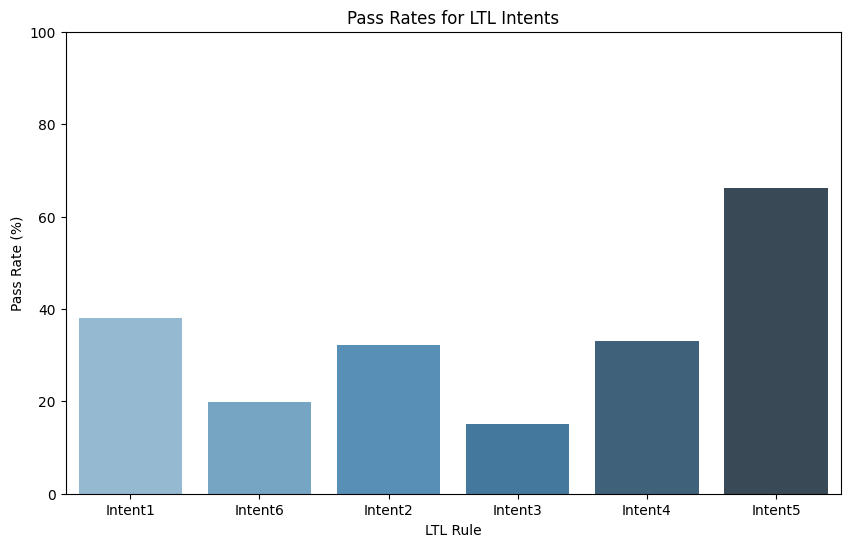

<ipython-input-3-3bd3528a3d85>:152: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, y="Intent_type", order=df["Intent_type"].value_counts().index, palette="Set2")


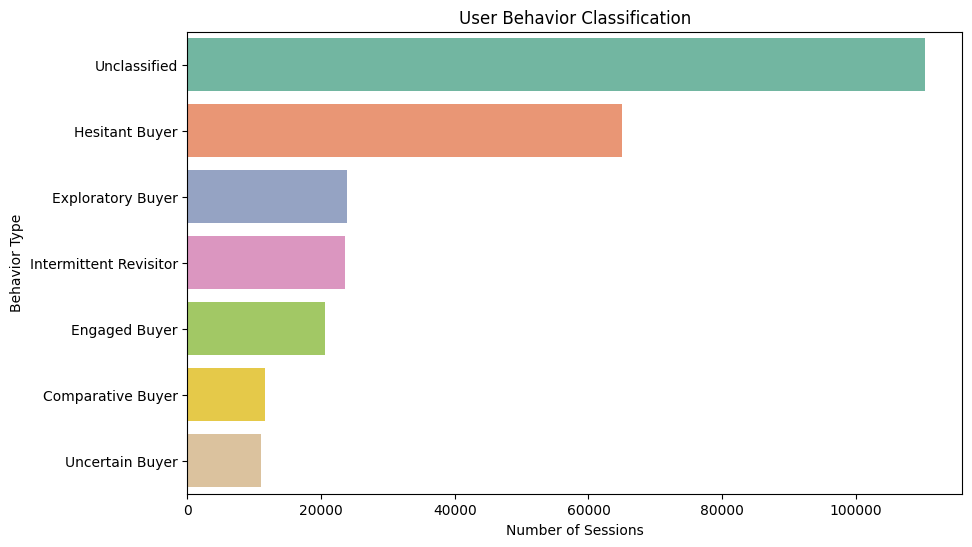

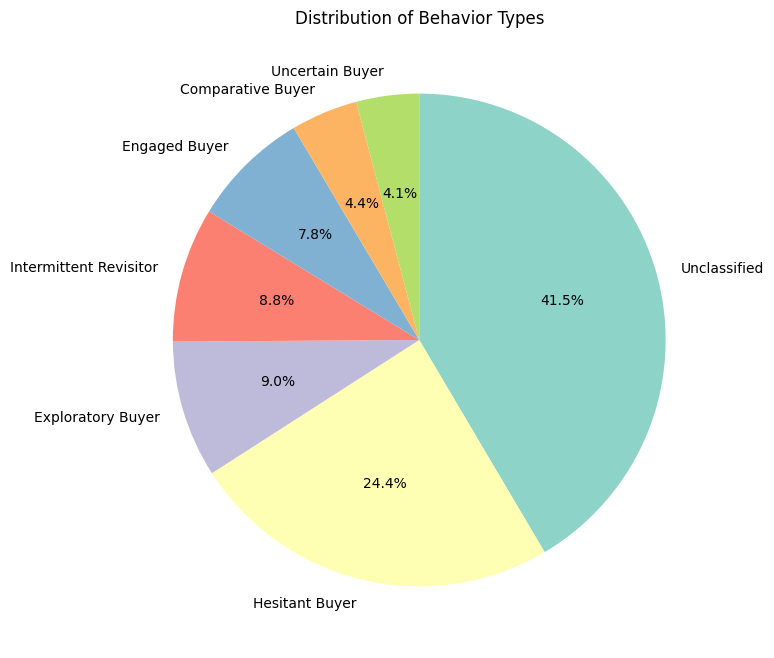

In [3]:
import pandas as pd
import ast
import matplotlib.pyplot as plt
import seaborn as sns
import time
# Step 1: Load data
df = pd.read_csv("browsing_seq_filtered_balanced_PCS955.csv")
df["behavior_sequence"] = df["behavior_sequence"].apply(ast.literal_eval)
df["server_timestamp_epoch_ms"] = df["server_timestamp_epoch_ms"].apply(ast.literal_eval)

# Step 2: Map symbolic trace
def map_events_with_dwell_time(events, timestamps):
    symbolic_trace = []
    for i, e in enumerate(events):
        dwell = (timestamps[i] - timestamps[i - 1]) / 1000 if i > 0 else 0
        if e == 1:
            if dwell < 5:
                symbolic_trace.append("browse_short")
            elif dwell >= 30:
                symbolic_trace.append("browse_long")
            else:
                symbolic_trace.append("browse")
        elif e == 2:
            symbolic_trace.append("detail_deep" if dwell >= 60 else "detail")
        elif e == 3:
            symbolic_trace.append("add")
        elif e == 4:
            symbolic_trace.append("remove")
        elif e == 5:
            symbolic_trace.append("purchase")
        else:
            symbolic_trace.append("unknown")
    return symbolic_trace

df.drop(columns=["symbolic_trace"], inplace=True, errors="ignore")
df["symbolic_trace"] = df.apply(lambda row: map_events_with_dwell_time(row["behavior_sequence"], row["server_timestamp_epoch_ms"]), axis=1)

# Step 3: Define LTL rules
def check_intent1(trace):
    if "browse_short" not in trace:
        return None
    for i, e in enumerate(trace):
        if e == "browse_short":
            window = trace[i+1:i+6]
            if any(x in window for x in ["browse_long", "detail", "detail_deep"]):
                continue
            return False
    return True

def check_intent2(trace):
    if "browse_long" not in trace:
        return None
    for i, e in enumerate(trace):
        if e == "browse_long":
            window = trace[i+1:i+6]
            if any(x in window for x in ["detail", "detail_deep"]):
                continue
            return False
    return True

def check_intent3(trace):
    if not any(e in trace for e in ["detail", "detail_deep"]):
        return None
    for i, e in enumerate(trace):
        if e in ["detail", "detail_deep"]:
            if not any(x in trace[i+1:] for x in ["add", "detail_deep"]):
                return False
    return True

def check_intent4(trace):
    if "add" not in trace:
        return None
    for i, e in enumerate(trace):
        if e == "add":
            window = trace[i+1:i+6]
            if any(x in window for x in ["remove", "detail", "detail_deep"]):
                continue
            return False
    return True

def check_intent5(trace):
    if "remove" not in trace:
        return None
    for i, e in enumerate(trace):
        if e == "remove":
            if not any(x in trace[i+1:] for x in ["browse_long", "detail", "detail_deep"]):
                return False
    return True

def check_intent6(trace):
    if "detail" not in trace or "browse_short" not in trace:
        return None
    for i in range(len(trace) - 2):
        if trace[i] == "detail" and trace[i+1] == "browse_short" and trace[i+2] == "detail":
            return True
    return False if "detail" in trace else None



rules = {
    "Intent1": check_intent1,
    "Intent6": check_intent6,  # must be here!
    "Intent2": check_intent2,
    "Intent3": check_intent3,
    "Intent4": check_intent4,
    "Intent5": check_intent5,
}
# Step 4: Apply all rules and measure total execution time
start_time = time.time()

for name, func in rules.items():
    df[name] = df["symbolic_trace"].apply(func)

end_time = time.time()
print(f"Total time for rule checking: {end_time - start_time:.2f} seconds")

# Step 5: Classify behavior type
def classify_intent_type(row):
    if all(row[r] is None for r in rules.keys()):
        return "Not Applicable"
    if row["Intent5"] is True:
        return "Uncertain Buyer"
    if row["Intent4"] is True:
        return "Comparative Buyer"
    if row["Intent3"] is True:
        return "Engaged Buyer"
    if row["Intent6"] is True:
        return "Intermittent Revisitor"
    if row["Intent2"] is True:
        return "Exploratory Buyer"
    if row["Intent1"] is True:
        return "Hesitant Buyer"
    return "Unclassified"

df["Intent_type"] = df.apply(classify_intent_type, axis=1)

# Step 6: Visualize results
passrate = pd.DataFrame({
    "Rule": list(rules.keys()),
    "PassRate": [df[r].dropna().mean() * 100 for r in rules.keys()]
})

plt.figure(figsize=(10, 6))
sns.barplot(data=passrate, x="Rule", y="PassRate", palette="Blues_d")
plt.ylim(0, 100)
plt.title("Pass Rates for LTL Intents")
plt.ylabel("Pass Rate (%)")
plt.xlabel("LTL Rule")
plt.show()

plt.figure(figsize=(10, 6))
sns.countplot(data=df, y="Intent_type", order=df["Intent_type"].value_counts().index, palette="Set2")
plt.title("User Behavior Classification")
plt.xlabel("Number of Sessions")
plt.ylabel("Behavior Type")
plt.show()

plt.figure(figsize=(8, 8))
df["Intent_type"].value_counts().plot.pie(autopct="%1.1f%%", startangle=90, counterclock=False, colors=sns.color_palette("Set3"))
plt.ylabel("")
plt.title("Distribution of Behavior Types")
plt.show()


In [5]:
df.to_csv("results.csv",index=False)

In [ ]:
!pip install upsetplot

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for upsetplot: filename=upsetplot-0.9.0-py3-none-any.whl size=24862 sha256=60bdd93ff1be499ad83d7c832c6bfe809987b8a8aa5dc99b91e87084fab1e6d3
  Stored in directory: /root/.cache/pip/wheels/7b/ce/88/1d0bce5b2680165c29c3e68416325e79674d5a9f422d037996
Successfully built upsetplot


<ipython-input-17-02de7ab2a6f5>:14: FutureWarning:

DataFrame.applymap has been deprecated. Use DataFrame.map instead.

/usr/local/lib/python3.11/dist-packages/upsetplot/plotting.py:795: FutureWarning:

A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.



/usr/local/lib/python3.11/dist-packages/upsetplot/plotting.py:796: FutureWarning:

A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate 

<Figure size 2000x600 with 0 Axes>

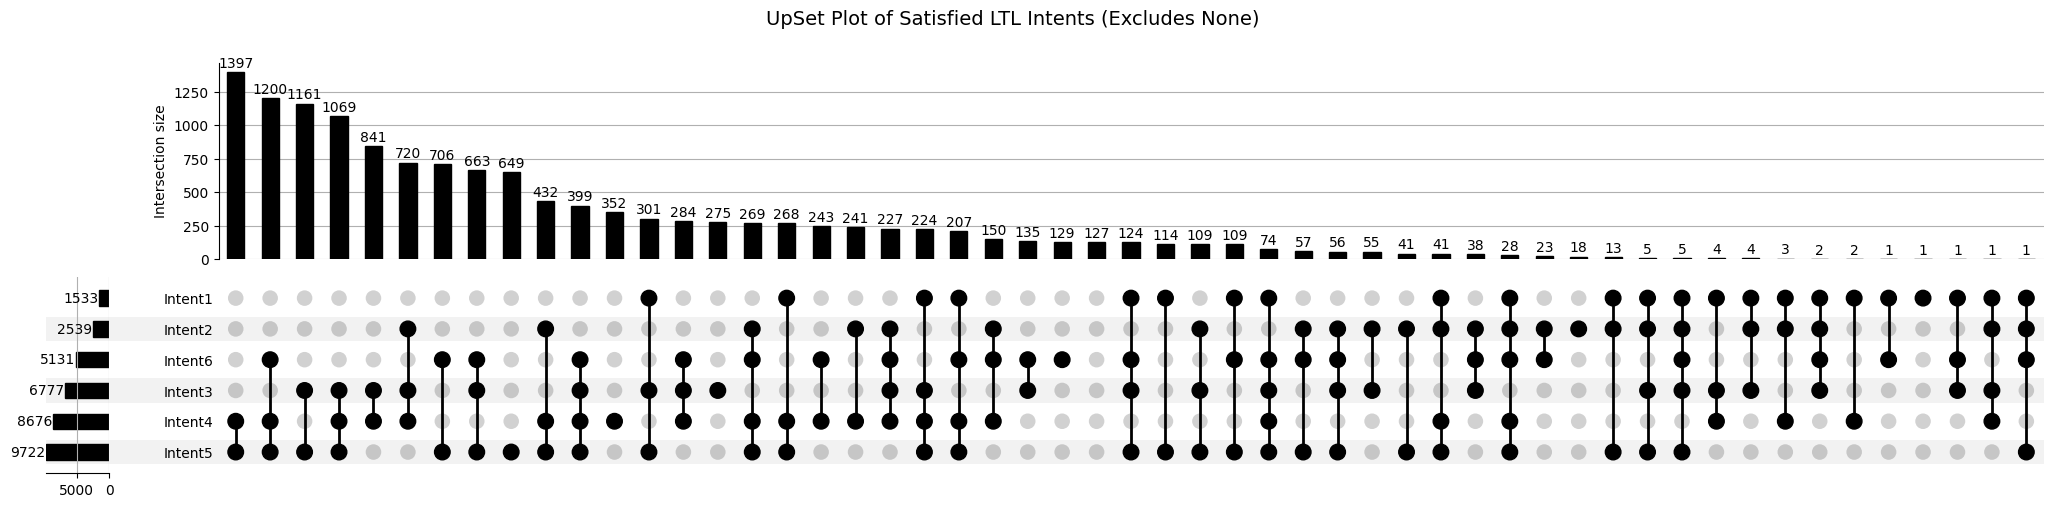

In [17]:
import pandas as pd
import numpy as np
from upsetplot import UpSet, from_indicators
import matplotlib.pyplot as plt

# 讀取資料
df = pd.read_csv("results.csv")  # 請確認路徑正確
rule_cols = ['Intent1', 'Intent2', 'Intent3', 'Intent4', 'Intent5', 'Intent6']

# 過濾掉含 None 的 row（只要某一欄為 None 就排除）
df_filtered = df.dropna(subset=rule_cols, how='any')

# 只保留 True 的標記（False 與 None 都視為不滿足）
df_satisfied_binary = df_filtered[rule_cols].applymap(lambda x: True if x is True else False)

# 建立 UpSet 資料
upset_data = from_indicators(df_satisfied_binary.columns.tolist(), df_satisfied_binary)

# 繪製 UpSet Plot
plt.figure(figsize=(20, 6))
up = UpSet(upset_data, show_counts=True, sort_by='cardinality')
up.plot()
plt.suptitle("UpSet Plot of Satisfied LTL Intents (Excludes None)", fontsize=14)
plt.tight_layout()
plt.show()


In [18]:
import pandas as pd
import plotly.graph_objects as go

# 載入 CSV
df = pd.read_csv("results.csv")

# 擷取第一個行為
df["first_action"] = df["symbolic_trace"].apply(lambda x: eval(x)[0] if isinstance(x, str) and len(eval(x)) > 0 else "unknown")

# 判斷是否有purchase
df["purchase_flag"] = df["symbolic_trace"].apply(lambda x: "purchase" if "purchase" in eval(x) else "no_purchase")

# 建立 Sankey DataFrame
sankey_df = df[["first_action", "Intent_type", "purchase_flag"]]

# 所有節點標籤
all_labels = pd.concat([
    sankey_df["first_action"],
    sankey_df["Intent_type"],
    sankey_df["purchase_flag"]
]).unique().tolist()
label_map = {label: i for i, label in enumerate(all_labels)}

# 組裝連結
def make_links(df, src, tgt):
    grouped = df.groupby([src, tgt]).size().reset_index(name='count')
    return {
        "source": grouped[src].map(label_map).tolist(),
        "target": grouped[tgt].map(label_map).tolist(),
        "value": grouped["count"].tolist()
    }

links1 = make_links(sankey_df, "first_action", "Intent_type")
links2 = make_links(sankey_df, "Intent_type", "purchase_flag")

# 合併連結
sankey_links = {
    "source": links1["source"] + links2["source"],
    "target": links1["target"] + links2["target"],
    "value": links1["value"] + links2["value"]
}

# 繪圖
fig = go.Figure(data=[go.Sankey(
    node=dict(pad=15, thickness=20, label=all_labels),
    link=sankey_links
)])
fig.update_layout(title_text="Sankey Diagram: First Action → Violation Type → Purchase Result", font_size=12)

# 匯出為 HTML
fig.write_html("results.html")


In [6]:
import pandas as pd
import ast

# 讀取原始 CSV 檔案
df = pd.read_csv("results.csv")  # 請依實際檔名修改

# 將字串欄位轉換為 list
df["behavior_sequence"] = df["behavior_sequence"].apply(ast.literal_eval)
df["server_timestamp_epoch_ms"] = df["server_timestamp_epoch_ms"].apply(ast.literal_eval)

# 定義截斷函數：排除首項為5，否則同步截斷至第一個5前
def truncate_before_purchase(seq, timestamps):
    if len(seq) > 0 and seq[0] == 5:
        return None, None, None  # 後續用來 drop
    if 5 in seq:
        idx = seq.index(5)
        return seq[:idx], timestamps[:idx], 1
    else:
        return seq, timestamps, 0

# 套用函數
df[["truncated_sequence", "truncated_timestamp", "purchase"]] = df.apply(
    lambda row: pd.Series(truncate_before_purchase(row["behavior_sequence"], row["server_timestamp_epoch_ms"])),
    axis=1
)

# 移除第一個行為就是 5 的 row（被標記為 None）
df.dropna(subset=["truncated_sequence"], inplace=True)

# 儲存結果
df.to_csv("results2.csv", index=False)

# 顯示確認
print(df[["behavior_sequence", "server_timestamp_epoch_ms", "truncated_sequence", "truncated_timestamp", "purchase"]].head())


                                   behavior_sequence  \
0                     [1, 1, 1, 2, 1, 1, 1, 2, 1, 1]   
2                                             [1, 2]   
3                                             [1, 2]   
4  [1, 1, 1, 1, 1, 1, 2, 1, 1, 2, 2, 1, 1, 2, 2, ...   
5                                 [1, 1, 1, 1, 1, 2]   

                           server_timestamp_epoch_ms  \
0  [3345998, 3434575, 3511282, 3531114, 3531114, ...   
2                                   [683257, 683257]   
3                                 [5963809, 5963809]   
4  [5251322, 5262403, 5275823, 5280318, 5336974, ...   
5  [7360993, 7366740, 7370232, 7374996, 7402120, ...   

                                  truncated_sequence  \
0                     [1, 1, 1, 2, 1, 1, 1, 2, 1, 1]   
2                                             [1, 2]   
3                                             [1, 2]   
4  [1, 1, 1, 1, 1, 1, 2, 1, 1, 2, 2, 1, 1, 2, 2, ...   
5                                 [1, 1, 1, 1,

In [26]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import ast

df = pd.read_csv("results2.csv")

# 處理序列Padding
MAXLEN = 30
intent_cols = ['Intent1', 'Intent2', 'Intent3', 'Intent4', 'Intent5', 'Intent6']

def pad_sequence(seq, maxlen=MAXLEN):
    return (seq + [0]*max(0, maxlen - len(seq)))[:maxlen]

df['truncated_sequence'] = df['truncated_sequence'].apply(ast.literal_eval)
df['X_seq'] = df['truncated_sequence'].apply(pad_sequence)

# Intent特徵 (NaN填False轉0/1)
for col in intent_cols:
    df[col] = df[col].fillna(False).astype(int)

# 全部資料
X_seq = np.array(df['X_seq'].tolist())
X_feat = df[intent_cols].values
y = df['purchase'].values

# 只要任一 Intent 是 True，保留
df_filtered = df[df[intent_cols].apply(lambda x: x.isin([False]).any(), axis=1)].copy()
X_seq_filtered = np.array(df_filtered['X_seq'].tolist())
X_feat_filtered = df_filtered[intent_cols].values
y_filtered = df_filtered['purchase'].values


<ipython-input-26-37c33dcfbfe7>:20: FutureWarning:

Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`

<ipython-input-26-37c33dcfbfe7>:20: FutureWarning:

Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`

<ipython-input-26-37c33dcfbfe7>:20: FutureWarning:

Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`

<ipython-input-26-37c33dcfbfe7>:20: FutureWarning:

Downcasting object dtype arrays on .fillna

In [27]:
import tensorflow as tf
from tensorflow.keras import layers, models, Input

VOCAB_SIZE = 6
EMBED_DIM = 64
NUM_HEADS = 4
FF_DIM = 128
NUM_LAYERS = 2
DROPOUT = 0.1
class MCDropout(tf.keras.layers.Dropout):
    def call(self, inputs, training=None):
        return super().call(inputs, training=True)

def create_model(model_type='sequence_only', interaction=False):
    inputs, concat_features = [], []

    if model_type != 'feat_only':
        seq_input = Input(shape=(MAXLEN,), name='sequence_input')
        x = layers.Embedding(VOCAB_SIZE, EMBED_DIM, mask_zero=True)(seq_input)
        pos_encoding = layers.Embedding(MAXLEN, EMBED_DIM)(tf.range(MAXLEN))
        x = x + pos_encoding

        for _ in range(NUM_LAYERS):
            attn_output = layers.MultiHeadAttention(NUM_HEADS, EMBED_DIM)(x, x)
            attn_output = layers.Dropout(DROPOUT)(attn_output)
            x = layers.LayerNormalization()(x + attn_output)
            ff_output = layers.Dense(FF_DIM, activation='relu')(x)
            ff_output = layers.Dense(EMBED_DIM)(ff_output)
            ff_output = layers.Dropout(DROPOUT)(ff_output)
            x = layers.LayerNormalization()(x + ff_output)
        seq_feat = layers.GlobalAveragePooling1D()(x)
        inputs.append(seq_input)
        concat_features.append(seq_feat)

    if model_type in ['with_feat', 'feat_only']:
        feat_input = Input(shape=(len(intent_cols),), name='extra_features')
        feat_feat = layers.Dense(EMBED_DIM, activation='relu')(feat_input)
        inputs.append(feat_input)
        concat_features.append(feat_feat)

    if interaction and len(concat_features) > 1:
        # Cross-attention Interaction Layer
        cross_out = layers.Attention()([concat_features[0][:, None, :], concat_features[1][:, None, :]])
        cross_out = layers.Flatten()(cross_out)
        x = layers.Concatenate()([*concat_features, cross_out])
    else:
        x = layers.Concatenate()(concat_features) if len(concat_features) > 1 else concat_features[0]

    x = layers.Dense(FF_DIM, activation='relu')(x)
    x = layers.Dropout(DROPOUT)(x)
    output = layers.Dense(1, activation='sigmoid')(x)

    model = models.Model(inputs=inputs, outputs=output)
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
def mc_predict(model, X_input, T=30):
    preds = np.stack([
        model.predict(X_input, verbose=0).squeeze()
        for _ in range(T)
    ], axis=0)
    return preds.mean(axis=0), preds.std(axis=0)

def train_eval(model, X_train, y_train, X_test, y_test, name, epochs=10):
    early_stop = tf.keras.callbacks.EarlyStopping(patience=3, restore_best_weights=True)
    model.fit(X_train, y_train, epochs=epochs, batch_size=32,
              validation_data=(X_test, y_test), callbacks=[early_stop])

    y_pred = (model.predict(X_test) > 0.5).astype(int)
    print(f"{name} Accuracy: {accuracy_score(y_test, y_pred):.4f}")
    print(f"{name} Precision: {precision_score(y_test, y_pred, zero_division=0):.4f}")
    print(f"{name} Recall: {recall_score(y_test, y_pred):.4f}")
    print(f"{name} F1 Score: {f1_score(y_test, y_pred):.4f}")
# Split data
X_seq_tr, X_seq_te, X_feat_tr, X_feat_te, y_tr, y_te = train_test_split(
    X_seq, X_feat, y, test_size=0.2, random_state=42)

X_seq_ftr, X_seq_fte, X_feat_ftr, X_feat_fte, y_ftr, y_fte = train_test_split(
    X_seq_filtered, X_feat_filtered, y_filtered, test_size=0.2, random_state=42)

# A1: 原始資料, 序列 only
train_eval(create_model('sequence_only'), X_seq_tr, y_tr, X_seq_te, y_te, "A1 (Baseline)")

# A2: 篩選資料, 序列 only
train_eval(create_model('sequence_only'), X_seq_ftr, y_ftr, X_seq_fte, y_fte, "A2 (Filtered Baseline)")

# B1: 原始資料, 序列 + LTL features
train_eval(create_model('with_feat'),
           {'sequence_input': X_seq_tr, 'extra_features': X_feat_tr}, y_tr,
           {'sequence_input': X_seq_te, 'extra_features': X_feat_te}, y_te, "B1 (Seq+LTL)")

# B2: 篩選資料, 序列 + LTL features
train_eval(create_model('with_feat'),
           {'sequence_input': X_seq_ftr, 'extra_features': X_feat_ftr}, y_ftr,
           {'sequence_input': X_seq_fte, 'extra_features': X_feat_fte}, y_fte, "B2 (Filtered Seq+LTL)")

# C1: 原始資料, LTL features only
train_eval(create_model('feat_only'),
           X_feat_tr, y_tr, X_feat_te, y_te, "C1 (LTL only)")

# D1: 原始資料, 序列 + LTL features + Interaction
train_eval(create_model('with_feat', interaction=True),
           {'sequence_input': X_seq_tr, 'extra_features': X_feat_tr}, y_tr,
           {'sequence_input': X_seq_te, 'extra_features': X_feat_te}, y_te, "D1 (Interaction Layer)")

In [37]:

import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models, Input
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Load dataset
df = pd.read_csv("results2.csv")
import ast
df['truncated_sequence'] = df['truncated_sequence'].apply(ast.literal_eval)
df['X_seq'] = df['truncated_sequence'].apply(lambda x: (x + [0]*30)[:30])
intent_cols = ['Intent1', 'Intent2', 'Intent3', 'Intent4', 'Intent5', 'Intent6']
for col in intent_cols:
    df[col] = df[col].fillna(False).astype(int)

X_seq = np.array(df['X_seq'].tolist())
X_feat = df[intent_cols].values
y = df['purchase'].values

# Filtered data (at least one True in intent)
df_filtered = df[df[intent_cols].apply(lambda x: x.isin([True]).any(), axis=1)].copy()
X_seq_filtered = np.array(df_filtered['X_seq'].tolist())
X_feat_filtered = df_filtered[intent_cols].values
y_filtered = df_filtered['purchase'].values

# Split
X_seq_tr, X_seq_te, X_feat_tr, X_feat_te, y_tr, y_te = train_test_split(X_seq, X_feat, y, test_size=0.2, random_state=42)
X_seq_ftr, X_seq_fte, X_feat_ftr, X_feat_fte, y_ftr, y_fte = train_test_split(X_seq_filtered, X_feat_filtered, y_filtered, test_size=0.2, random_state=42)

# MC Dropout
class MCDropout(tf.keras.layers.Dropout):
    def call(self, inputs, training=None):
        return super().call(inputs, training=True)

# Create model
def create_lstm_mc_model(model_type='sequence_only', interaction=False):
    MAXLEN = 30
    VOCAB_SIZE = 6
    EMBED_DIM = 32
    LSTM_UNITS = 64
    FF_DIM = 64
    DROPOUT = 0.3

    inputs, concat_features = [], []

    if model_type != 'feat_only':
        seq_input = Input(shape=(MAXLEN,), name='sequence_input')
        x = layers.Embedding(VOCAB_SIZE, EMBED_DIM, mask_zero=True)(seq_input)
        x = layers.LSTM(LSTM_UNITS, return_sequences=False)(x)
        x = MCDropout(DROPOUT)(x)
        inputs.append(seq_input)
        concat_features.append(x)

    if model_type in ['with_feat', 'feat_only']:
        feat_input = Input(shape=(6,), name='extra_features')
        feat_proj = layers.Dense(EMBED_DIM, activation='relu')(feat_input)
        inputs.append(feat_input)
        concat_features.append(feat_proj)

    if interaction and len(concat_features) > 1:
        cross = layers.Concatenate()(concat_features)
        cross = layers.Dense(EMBED_DIM, activation='relu')(cross)
        x = layers.Concatenate()([*concat_features, cross])
    else:
        x = layers.Concatenate()(concat_features) if len(concat_features) > 1 else concat_features[0]

    x = layers.Dense(FF_DIM, activation='relu')(x)
    x = MCDropout(DROPOUT)(x)
    output = layers.Dense(1, activation='sigmoid')(x)

    model = models.Model(inputs=inputs, outputs=output)
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

# MC Dropout inference
def mc_predict(model, X_input, T=10):
    preds = np.stack([model.predict(X_input, verbose=0).squeeze() for _ in range(T)], axis=0)
    print(1)
    return preds.mean(axis=0), preds.std(axis=0)

# Save CSV
def save_mc_predictions(y_prob, y_std, y_true, filename):
    df_out = pd.DataFrame({
        "y_true": y_true,
        "y_prob": y_prob,
        "uncertainty_std": y_std
    })
    df_out.to_csv(filename, index=False)
    print(f"📁 Saved: {filename}")

# Train + Evaluate
def train_eval(model, X_train, y_train, X_test, y_test, name, T=10):
    print(f"\n🚀 Training {name}...")
    cb = tf.keras.callbacks.EarlyStopping(patience=3, restore_best_weights=True)

    # 自動判斷是否需要 dictionary 格式（具名輸入）
    if isinstance(model.input, list):
        X_train_input = {"sequence_input": X_train} if isinstance(X_train, np.ndarray) else X_train
        X_test_input = {"sequence_input": X_test} if isinstance(X_test, np.ndarray) else X_test
    else:
        X_train_input = X_train
        X_test_input = X_test

    model.fit(X_train_input, y_train, epochs=10, batch_size=32,
              validation_data=(X_test_input, y_test), callbacks=[cb], verbose=1)

    print(f"🔎 Predicting with MC Dropout (T={T})...")
    y_prob, y_std = mc_predict(model, X_test_input, T)
    y_pred = (y_prob > 0.5).astype(int)

    print(f"\n📊 {name} Evaluation:")
    print("Accuracy :", accuracy_score(y_test, y_pred))
    print("Precision:", precision_score(y_test, y_pred, zero_division=0))
    print("Recall   :", recall_score(y_test, y_pred))
    print("F1 Score :", f1_score(y_test, y_pred))
    print("Mean Uncertainty:", y_std.mean())

    save_mc_predictions(y_prob, y_std, y_test, f"{name}_mc.csv")
    model.save(f"{name}.h5")
    print(f"✅ Model saved as {name}.h5")

# Run all models
train_eval(create_lstm_mc_model('sequence_only'), X_seq_tr, y_tr, X_seq_te, y_te, "A1")






<ipython-input-37-43927e47df0b>:15: FutureWarning:

Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`

<ipython-input-37-43927e47df0b>:15: FutureWarning:

Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`

<ipython-input-37-43927e47df0b>:15: FutureWarning:

Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`

<ipython-input-37-43927e47df0b>:15: FutureWarning:

Downcasting object dtype arrays on .fillna


🚀 Training A1...
Epoch 1/10
6590/6590 ━━━━━━━━━━━━━━━━━━━━ 279s 42ms/step - accuracy: 0.9271 - loss: 0.2170 - val_accuracy: 0.9448 - val_loss: 0.1727
Epoch 2/10
6590/6590 ━━━━━━━━━━━━━━━━━━━━ 266s 33ms/step - accuracy: 0.9448 - loss: 0.1719 - val_accuracy: 0.9448 - val_loss: 0.1723
Epoch 3/10
6590/6590 ━━━━━━━━━━━━━━━━━━━━ 257s 33ms/step - accuracy: 0.9458 - loss: 0.1683 - val_accuracy: 0.9462 - val_loss: 0.1675
Epoch 4/10
6590/6590 ━━━━━━━━━━━━━━━━━━━━ 214s 32ms/step - accuracy: 0.9452 - loss: 0.1698 - val_accuracy: 0.9464 - val_loss: 0.1666
Epoch 5/10
6590/6590 ━━━━━━━━━━━━━━━━━━━━ 258s 32ms/step - accuracy: 0.9461 - loss: 0.1669 - val_accuracy: 0.9469 - val_loss: 0.1651
Epoch 6/10
6590/6590 ━━━━━━━━━━━━━━━━━━━━ 207s 31ms/step - accuracy: 0.9454 - loss: 0.1673 - val_accuracy: 0.9466 - val_loss: 0.1651
Epoch 7/10
6590/6590 ━━━━━━━━━━━━━━━━━━━━ 268s 32ms/step - accuracy: 0.9468 - loss: 0.1655 - val_accuracy: 0.9468 - val_loss: 0.1649
Epoch 8/10
6590/6590 ━━━━━━━━━━━━━━━━━━━━ 255s 31ms

📁 Saved: A1_mc.csv
✅ Model saved as A1.h5


In [38]:

import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models, Input
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Load dataset
df = pd.read_csv("results2.csv")
import ast
df['truncated_sequence'] = df['truncated_sequence'].apply(ast.literal_eval)
df['X_seq'] = df['truncated_sequence'].apply(lambda x: (x + [0]*30)[:30])
intent_cols = ['Intent1', 'Intent2', 'Intent3', 'Intent4', 'Intent5', 'Intent6']
for col in intent_cols:
    df[col] = df[col].fillna(False).astype(int)

X_seq = np.array(df['X_seq'].tolist())
X_feat = df[intent_cols].values
y = df['purchase'].values

# Filtered data (at least one True in intent)
df_filtered = df[df[intent_cols].apply(lambda x: x.isin([True]).any(), axis=1)].copy()
X_seq_filtered = np.array(df_filtered['X_seq'].tolist())
X_feat_filtered = df_filtered[intent_cols].values
y_filtered = df_filtered['purchase'].values

# Split
X_seq_tr, X_seq_te, X_feat_tr, X_feat_te, y_tr, y_te = train_test_split(X_seq, X_feat, y, test_size=0.2, random_state=42)
X_seq_ftr, X_seq_fte, X_feat_ftr, X_feat_fte, y_ftr, y_fte = train_test_split(X_seq_filtered, X_feat_filtered, y_filtered, test_size=0.2, random_state=42)

# MC Dropout
class MCDropout(tf.keras.layers.Dropout):
    def call(self, inputs, training=None):
        return super().call(inputs, training=True)

# Create model
def create_lstm_mc_model(model_type='sequence_only', interaction=False):
    MAXLEN = 30
    VOCAB_SIZE = 6
    EMBED_DIM = 32
    LSTM_UNITS = 64
    FF_DIM = 64
    DROPOUT = 0.3

    inputs, concat_features = [], []

    if model_type != 'feat_only':
        seq_input = Input(shape=(MAXLEN,), name='sequence_input')
        x = layers.Embedding(VOCAB_SIZE, EMBED_DIM, mask_zero=True)(seq_input)
        x = layers.LSTM(LSTM_UNITS, return_sequences=False)(x)
        x = MCDropout(DROPOUT)(x)
        inputs.append(seq_input)
        concat_features.append(x)

    if model_type in ['with_feat', 'feat_only']:
        feat_input = Input(shape=(6,), name='extra_features')
        feat_proj = layers.Dense(EMBED_DIM, activation='relu')(feat_input)
        inputs.append(feat_input)
        concat_features.append(feat_proj)

    if interaction and len(concat_features) > 1:
        cross = layers.Concatenate()(concat_features)
        cross = layers.Dense(EMBED_DIM, activation='relu')(cross)
        x = layers.Concatenate()([*concat_features, cross])
    else:
        x = layers.Concatenate()(concat_features) if len(concat_features) > 1 else concat_features[0]

    x = layers.Dense(FF_DIM, activation='relu')(x)
    x = MCDropout(DROPOUT)(x)
    output = layers.Dense(1, activation='sigmoid')(x)

    model = models.Model(inputs=inputs, outputs=output)
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

# MC Dropout inference
def mc_predict(model, X_input, T=10):
    preds = np.stack([model.predict(X_input, verbose=0).squeeze() for _ in range(T)], axis=0)
    print(1)
    return preds.mean(axis=0), preds.std(axis=0)

# Save CSV
def save_mc_predictions(y_prob, y_std, y_true, filename):
    df_out = pd.DataFrame({
        "y_true": y_true,
        "y_prob": y_prob,
        "uncertainty_std": y_std
    })
    df_out.to_csv(filename, index=False)
    print(f"📁 Saved: {filename}")

# Train + Evaluate
def train_eval(model, X_train, y_train, X_test, y_test, name, T=10):
    print(f"\n🚀 Training {name}...")
    cb = tf.keras.callbacks.EarlyStopping(patience=3, restore_best_weights=True)

    # 自動判斷是否需要 dictionary 格式（具名輸入）
    if isinstance(model.input, list):
        X_train_input = {"sequence_input": X_train} if isinstance(X_train, np.ndarray) else X_train
        X_test_input = {"sequence_input": X_test} if isinstance(X_test, np.ndarray) else X_test
    else:
        X_train_input = X_train
        X_test_input = X_test

    model.fit(X_train_input, y_train, epochs=10, batch_size=32,
              validation_data=(X_test_input, y_test), callbacks=[cb], verbose=1)

    print(f"🔎 Predicting with MC Dropout (T={T})...")
    y_prob, y_std = mc_predict(model, X_test_input, T)
    y_pred = (y_prob > 0.5).astype(int)

    print(f"\n📊 {name} Evaluation:")
    print("Accuracy :", accuracy_score(y_test, y_pred))
    print("Precision:", precision_score(y_test, y_pred, zero_division=0))
    print("Recall   :", recall_score(y_test, y_pred))
    print("F1 Score :", f1_score(y_test, y_pred))
    print("Mean Uncertainty:", y_std.mean())

    save_mc_predictions(y_prob, y_std, y_test, f"{name}_mc.csv")
    model.save(f"{name}.h5")
    print(f"✅ Model saved as {name}.h5")

# Run all models

train_eval(create_lstm_mc_model('sequence_only'), X_seq_ftr, y_ftr, X_seq_fte, y_fte, "A2")





<ipython-input-38-8e7e916e5604>:15: FutureWarning:

Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`

<ipython-input-38-8e7e916e5604>:15: FutureWarning:

Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`

<ipython-input-38-8e7e916e5604>:15: FutureWarning:

Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`

<ipython-input-38-8e7e916e5604>:15: FutureWarning:

Downcasting object dtype arrays on .fillna


🚀 Training A2...
Epoch 1/10
3872/3872 ━━━━━━━━━━━━━━━━━━━━ 136s 34ms/step - accuracy: 0.9003 - loss: 0.2552 - val_accuracy: 0.9273 - val_loss: 0.1954
Epoch 2/10
3872/3872 ━━━━━━━━━━━━━━━━━━━━ 137s 32ms/step - accuracy: 0.9292 - loss: 0.1933 - val_accuracy: 0.9309 - val_loss: 0.1899
Epoch 3/10
3872/3872 ━━━━━━━━━━━━━━━━━━━━ 141s 32ms/step - accuracy: 0.9340 - loss: 0.1883 - val_accuracy: 0.9343 - val_loss: 0.1827
Epoch 4/10
3872/3872 ━━━━━━━━━━━━━━━━━━━━ 125s 32ms/step - accuracy: 0.9366 - loss: 0.1789 - val_accuracy: 0.9341 - val_loss: 0.1836
Epoch 5/10
3872/3872 ━━━━━━━━━━━━━━━━━━━━ 145s 33ms/step - accuracy: 0.9358 - loss: 0.1793 - val_accuracy: 0.9353 - val_loss: 0.1816
Epoch 6/10
3872/3872 ━━━━━━━━━━━━━━━━━━━━ 142s 33ms/step - accuracy: 0.9368 - loss: 0.1760 - val_accuracy: 0.9351 - val_loss: 0.1813
Epoch 7/10
3872/3872 ━━━━━━━━━━━━━━━━━━━━ 141s 33ms/step - accuracy: 0.9372 - loss: 0.1763 - val_accuracy: 0.9355 - val_loss: 0.1783
Epoch 8/10
3872/3872 ━━━━━━━━━━━━━━━━━━━━ 140s 33ms

1

📊 A2 Evaluation:
Accuracy : 0.9362286083306426
Precision: 0.8967469879518072
Recall   : 0.8694077794650158
F1 Score : 0.882865784947512
Mean Uncertainty: 0.018680464
📁 Saved: A2_mc.csv
✅ Model saved as A2.h5


In [39]:

import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models, Input
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Load dataset
df = pd.read_csv("results2.csv")
import ast
df['truncated_sequence'] = df['truncated_sequence'].apply(ast.literal_eval)
df['X_seq'] = df['truncated_sequence'].apply(lambda x: (x + [0]*30)[:30])
intent_cols = ['Intent1', 'Intent2', 'Intent3', 'Intent4', 'Intent5', 'Intent6']
for col in intent_cols:
    df[col] = df[col].fillna(False).astype(int)

X_seq = np.array(df['X_seq'].tolist())
X_feat = df[intent_cols].values
y = df['purchase'].values

# Filtered data (at least one True in intent)
df_filtered = df[df[intent_cols].apply(lambda x: x.isin([True]).any(), axis=1)].copy()
X_seq_filtered = np.array(df_filtered['X_seq'].tolist())
X_feat_filtered = df_filtered[intent_cols].values
y_filtered = df_filtered['purchase'].values

# Split
X_seq_tr, X_seq_te, X_feat_tr, X_feat_te, y_tr, y_te = train_test_split(X_seq, X_feat, y, test_size=0.2, random_state=42)
X_seq_ftr, X_seq_fte, X_feat_ftr, X_feat_fte, y_ftr, y_fte = train_test_split(X_seq_filtered, X_feat_filtered, y_filtered, test_size=0.2, random_state=42)

# MC Dropout
class MCDropout(tf.keras.layers.Dropout):
    def call(self, inputs, training=None):
        return super().call(inputs, training=True)

# Create model
def create_lstm_mc_model(model_type='sequence_only', interaction=False):
    MAXLEN = 30
    VOCAB_SIZE = 6
    EMBED_DIM = 32
    LSTM_UNITS = 64
    FF_DIM = 64
    DROPOUT = 0.3

    inputs, concat_features = [], []

    if model_type != 'feat_only':
        seq_input = Input(shape=(MAXLEN,), name='sequence_input')
        x = layers.Embedding(VOCAB_SIZE, EMBED_DIM, mask_zero=True)(seq_input)
        x = layers.LSTM(LSTM_UNITS, return_sequences=False)(x)
        x = MCDropout(DROPOUT)(x)
        inputs.append(seq_input)
        concat_features.append(x)

    if model_type in ['with_feat', 'feat_only']:
        feat_input = Input(shape=(6,), name='extra_features')
        feat_proj = layers.Dense(EMBED_DIM, activation='relu')(feat_input)
        inputs.append(feat_input)
        concat_features.append(feat_proj)

    if interaction and len(concat_features) > 1:
        cross = layers.Concatenate()(concat_features)
        cross = layers.Dense(EMBED_DIM, activation='relu')(cross)
        x = layers.Concatenate()([*concat_features, cross])
    else:
        x = layers.Concatenate()(concat_features) if len(concat_features) > 1 else concat_features[0]

    x = layers.Dense(FF_DIM, activation='relu')(x)
    x = MCDropout(DROPOUT)(x)
    output = layers.Dense(1, activation='sigmoid')(x)

    model = models.Model(inputs=inputs, outputs=output)
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

# MC Dropout inference
def mc_predict(model, X_input, T=10):
    preds = np.stack([model.predict(X_input, verbose=0).squeeze() for _ in range(T)], axis=0)
    print(1)
    return preds.mean(axis=0), preds.std(axis=0)

# Save CSV
def save_mc_predictions(y_prob, y_std, y_true, filename):
    df_out = pd.DataFrame({
        "y_true": y_true,
        "y_prob": y_prob,
        "uncertainty_std": y_std
    })
    df_out.to_csv(filename, index=False)
    print(f"📁 Saved: {filename}")

# Train + Evaluate
def train_eval(model, X_train, y_train, X_test, y_test, name, T=10):
    print(f"\n🚀 Training {name}...")
    cb = tf.keras.callbacks.EarlyStopping(patience=3, restore_best_weights=True)

    # 自動判斷是否需要 dictionary 格式（具名輸入）
    if isinstance(model.input, list):
        X_train_input = {"sequence_input": X_train} if isinstance(X_train, np.ndarray) else X_train
        X_test_input = {"sequence_input": X_test} if isinstance(X_test, np.ndarray) else X_test
    else:
        X_train_input = X_train
        X_test_input = X_test

    model.fit(X_train_input, y_train, epochs=10, batch_size=32,
              validation_data=(X_test_input, y_test), callbacks=[cb], verbose=1)

    print(f"🔎 Predicting with MC Dropout (T={T})...")
    y_prob, y_std = mc_predict(model, X_test_input, T)
    y_pred = (y_prob > 0.5).astype(int)

    print(f"\n📊 {name} Evaluation:")
    print("Accuracy :", accuracy_score(y_test, y_pred))
    print("Precision:", precision_score(y_test, y_pred, zero_division=0))
    print("Recall   :", recall_score(y_test, y_pred))
    print("F1 Score :", f1_score(y_test, y_pred))
    print("Mean Uncertainty:", y_std.mean())

    save_mc_predictions(y_prob, y_std, y_test, f"{name}_mc.csv")
    model.save(f"{name}.h5")
    print(f"✅ Model saved as {name}.h5")

# Run all models

train_eval(create_lstm_mc_model('with_feat'),
           {'sequence_input': X_seq_tr, 'extra_features': X_feat_tr}, y_tr,
           {'sequence_input': X_seq_te, 'extra_features': X_feat_te}, y_te, "B1")



<ipython-input-39-ae6d3759aceb>:15: FutureWarning:

Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`

<ipython-input-39-ae6d3759aceb>:15: FutureWarning:

Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`

<ipython-input-39-ae6d3759aceb>:15: FutureWarning:

Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`

<ipython-input-39-ae6d3759aceb>:15: FutureWarning:

Downcasting object dtype arrays on .fillna


🚀 Training B1...
Epoch 1/10
6590/6590 ━━━━━━━━━━━━━━━━━━━━ 227s 34ms/step - accuracy: 0.9396 - loss: 0.1865 - val_accuracy: 0.9579 - val_loss: 0.1430
Epoch 2/10
6590/6590 ━━━━━━━━━━━━━━━━━━━━ 222s 34ms/step - accuracy: 0.9592 - loss: 0.1401 - val_accuracy: 0.9598 - val_loss: 0.1363
Epoch 3/10
6590/6590 ━━━━━━━━━━━━━━━━━━━━ 255s 33ms/step - accuracy: 0.9599 - loss: 0.1366 - val_accuracy: 0.9607 - val_loss: 0.1357
Epoch 4/10
6590/6590 ━━━━━━━━━━━━━━━━━━━━ 257s 32ms/step - accuracy: 0.9613 - loss: 0.1335 - val_accuracy: 0.9611 - val_loss: 0.1320
Epoch 5/10
6590/6590 ━━━━━━━━━━━━━━━━━━━━ 206s 31ms/step - accuracy: 0.9628 - loss: 0.1296 - val_accuracy: 0.9613 - val_loss: 0.1328
Epoch 6/10
6590/6590 ━━━━━━━━━━━━━━━━━━━━ 269s 32ms/step - accuracy: 0.9623 - loss: 0.1320 - val_accuracy: 0.9622 - val_loss: 0.1302
Epoch 7/10
6590/6590 ━━━━━━━━━━━━━━━━━━━━ 254s 31ms/step - accuracy: 0.9630 - loss: 0.1285 - val_accuracy: 0.9623 - val_loss: 0.1305
Epoch 8/10
6590/6590 ━━━━━━━━━━━━━━━━━━━━ 262s 31ms

📁 Saved: B1_mc.csv
✅ Model saved as B1.h5


In [40]:

import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models, Input
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Load dataset
df = pd.read_csv("results2.csv")
import ast
df['truncated_sequence'] = df['truncated_sequence'].apply(ast.literal_eval)
df['X_seq'] = df['truncated_sequence'].apply(lambda x: (x + [0]*30)[:30])
intent_cols = ['Intent1', 'Intent2', 'Intent3', 'Intent4', 'Intent5', 'Intent6']
for col in intent_cols:
    df[col] = df[col].fillna(False).astype(int)

X_seq = np.array(df['X_seq'].tolist())
X_feat = df[intent_cols].values
y = df['purchase'].values

# Filtered data (at least one True in intent)
df_filtered = df[df[intent_cols].apply(lambda x: x.isin([True]).any(), axis=1)].copy()
X_seq_filtered = np.array(df_filtered['X_seq'].tolist())
X_feat_filtered = df_filtered[intent_cols].values
y_filtered = df_filtered['purchase'].values

# Split
X_seq_tr, X_seq_te, X_feat_tr, X_feat_te, y_tr, y_te = train_test_split(X_seq, X_feat, y, test_size=0.2, random_state=42)
X_seq_ftr, X_seq_fte, X_feat_ftr, X_feat_fte, y_ftr, y_fte = train_test_split(X_seq_filtered, X_feat_filtered, y_filtered, test_size=0.2, random_state=42)

# MC Dropout
class MCDropout(tf.keras.layers.Dropout):
    def call(self, inputs, training=None):
        return super().call(inputs, training=True)

# Create model
def create_lstm_mc_model(model_type='sequence_only', interaction=False):
    MAXLEN = 30
    VOCAB_SIZE = 6
    EMBED_DIM = 32
    LSTM_UNITS = 64
    FF_DIM = 64
    DROPOUT = 0.3

    inputs, concat_features = [], []

    if model_type != 'feat_only':
        seq_input = Input(shape=(MAXLEN,), name='sequence_input')
        x = layers.Embedding(VOCAB_SIZE, EMBED_DIM, mask_zero=True)(seq_input)
        x = layers.LSTM(LSTM_UNITS, return_sequences=False)(x)
        x = MCDropout(DROPOUT)(x)
        inputs.append(seq_input)
        concat_features.append(x)

    if model_type in ['with_feat', 'feat_only']:
        feat_input = Input(shape=(6,), name='extra_features')
        feat_proj = layers.Dense(EMBED_DIM, activation='relu')(feat_input)
        inputs.append(feat_input)
        concat_features.append(feat_proj)

    if interaction and len(concat_features) > 1:
        cross = layers.Concatenate()(concat_features)
        cross = layers.Dense(EMBED_DIM, activation='relu')(cross)
        x = layers.Concatenate()([*concat_features, cross])
    else:
        x = layers.Concatenate()(concat_features) if len(concat_features) > 1 else concat_features[0]

    x = layers.Dense(FF_DIM, activation='relu')(x)
    x = MCDropout(DROPOUT)(x)
    output = layers.Dense(1, activation='sigmoid')(x)

    model = models.Model(inputs=inputs, outputs=output)
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

# MC Dropout inference
def mc_predict(model, X_input, T=10):
    preds = np.stack([model.predict(X_input, verbose=0).squeeze() for _ in range(T)], axis=0)
    print(1)
    return preds.mean(axis=0), preds.std(axis=0)

# Save CSV
def save_mc_predictions(y_prob, y_std, y_true, filename):
    df_out = pd.DataFrame({
        "y_true": y_true,
        "y_prob": y_prob,
        "uncertainty_std": y_std
    })
    df_out.to_csv(filename, index=False)
    print(f"📁 Saved: {filename}")

# Train + Evaluate
def train_eval(model, X_train, y_train, X_test, y_test, name, T=10):
    print(f"\n🚀 Training {name}...")
    cb = tf.keras.callbacks.EarlyStopping(patience=3, restore_best_weights=True)

    # 自動判斷是否需要 dictionary 格式（具名輸入）
    if isinstance(model.input, list):
        X_train_input = {"sequence_input": X_train} if isinstance(X_train, np.ndarray) else X_train
        X_test_input = {"sequence_input": X_test} if isinstance(X_test, np.ndarray) else X_test
    else:
        X_train_input = X_train
        X_test_input = X_test

    model.fit(X_train_input, y_train, epochs=10, batch_size=32,
              validation_data=(X_test_input, y_test), callbacks=[cb], verbose=1)

    print(f"🔎 Predicting with MC Dropout (T={T})...")
    y_prob, y_std = mc_predict(model, X_test_input, T)
    y_pred = (y_prob > 0.5).astype(int)

    print(f"\n📊 {name} Evaluation:")
    print("Accuracy :", accuracy_score(y_test, y_pred))
    print("Precision:", precision_score(y_test, y_pred, zero_division=0))
    print("Recall   :", recall_score(y_test, y_pred))
    print("F1 Score :", f1_score(y_test, y_pred))
    print("Mean Uncertainty:", y_std.mean())

    save_mc_predictions(y_prob, y_std, y_test, f"{name}_mc.csv")
    model.save(f"{name}.h5")
    print(f"✅ Model saved as {name}.h5")

# Run all models


train_eval(create_lstm_mc_model('with_feat'),
           {'sequence_input': X_seq_ftr, 'extra_features': X_feat_ftr}, y_ftr,
           {'sequence_input': X_seq_fte, 'extra_features': X_feat_fte}, y_fte, "B2")



<ipython-input-40-42ed0a650442>:15: FutureWarning:

Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`

<ipython-input-40-42ed0a650442>:15: FutureWarning:

Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`

<ipython-input-40-42ed0a650442>:15: FutureWarning:

Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`

<ipython-input-40-42ed0a650442>:15: FutureWarning:

Downcasting object dtype arrays on .fillna


🚀 Training B2...
Epoch 1/10
3872/3872 ━━━━━━━━━━━━━━━━━━━━ 135s 33ms/step - accuracy: 0.9240 - loss: 0.2075 - val_accuracy: 0.9500 - val_loss: 0.1554
Epoch 2/10
3872/3872 ━━━━━━━━━━━━━━━━━━━━ 140s 33ms/step - accuracy: 0.9540 - loss: 0.1463 - val_accuracy: 0.9549 - val_loss: 0.1444
Epoch 3/10
3872/3872 ━━━━━━━━━━━━━━━━━━━━ 139s 32ms/step - accuracy: 0.9568 - loss: 0.1390 - val_accuracy: 0.9561 - val_loss: 0.1392
Epoch 4/10
3872/3872 ━━━━━━━━━━━━━━━━━━━━ 143s 32ms/step - accuracy: 0.9582 - loss: 0.1340 - val_accuracy: 0.9570 - val_loss: 0.1411
Epoch 5/10
3872/3872 ━━━━━━━━━━━━━━━━━━━━ 125s 32ms/step - accuracy: 0.9593 - loss: 0.1311 - val_accuracy: 0.9577 - val_loss: 0.1366
Epoch 6/10
3872/3872 ━━━━━━━━━━━━━━━━━━━━ 140s 32ms/step - accuracy: 0.9599 - loss: 0.1298 - val_accuracy: 0.9567 - val_loss: 0.1387
Epoch 7/10
3872/3872 ━━━━━━━━━━━━━━━━━━━━ 124s 32ms/step - accuracy: 0.9601 - loss: 0.1282 - val_accuracy: 0.9570 - val_loss: 0.1356
Epoch 8/10
3872/3872 ━━━━━━━━━━━━━━━━━━━━ 139s 31ms

📁 Saved: B2_mc.csv
✅ Model saved as B2.h5


In [43]:

import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models, Input
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Load dataset
df = pd.read_csv("results2.csv")
import ast
df['truncated_sequence'] = df['truncated_sequence'].apply(ast.literal_eval)
df['X_seq'] = df['truncated_sequence'].apply(lambda x: (x + [0]*30)[:30])
intent_cols = ['Intent1', 'Intent2', 'Intent3', 'Intent4', 'Intent5', 'Intent6']
for col in intent_cols:
    df[col] = df[col].fillna(False).astype(int)

X_seq = np.array(df['X_seq'].tolist())
X_feat = df[intent_cols].values
y = df['purchase'].values

# Filtered data (at least one True in intent)
df_filtered = df[df[intent_cols].apply(lambda x: x.isin([True]).any(), axis=1)].copy()
X_seq_filtered = np.array(df_filtered['X_seq'].tolist())
X_feat_filtered = df_filtered[intent_cols].values
y_filtered = df_filtered['purchase'].values

# Split
X_seq_tr, X_seq_te, X_feat_tr, X_feat_te, y_tr, y_te = train_test_split(X_seq, X_feat, y, test_size=0.2, random_state=42)
X_seq_ftr, X_seq_fte, X_feat_ftr, X_feat_fte, y_ftr, y_fte = train_test_split(X_seq_filtered, X_feat_filtered, y_filtered, test_size=0.2, random_state=42)

# MC Dropout
class MCDropout(tf.keras.layers.Dropout):
    def call(self, inputs, training=None):
        return super().call(inputs, training=True)

# Create model
def create_lstm_mc_model(model_type='sequence_only', interaction=False):
    MAXLEN = 30
    VOCAB_SIZE = 6
    EMBED_DIM = 32
    LSTM_UNITS = 64
    FF_DIM = 64
    DROPOUT = 0.3

    inputs, concat_features = [], []

    if model_type != 'feat_only':
        seq_input = Input(shape=(MAXLEN,), name='sequence_input')
        x = layers.Embedding(VOCAB_SIZE, EMBED_DIM, mask_zero=True)(seq_input)
        x = layers.LSTM(LSTM_UNITS, return_sequences=False)(x)
        x = MCDropout(DROPOUT)(x)
        inputs.append(seq_input)
        concat_features.append(x)

    if model_type in ['with_feat', 'feat_only']:
        feat_input = Input(shape=(6,), name='extra_features')
        feat_proj = layers.Dense(EMBED_DIM, activation='relu')(feat_input)
        inputs.append(feat_input)
        concat_features.append(feat_proj)

    if interaction and len(concat_features) > 1:
        cross = layers.Concatenate()(concat_features)
        cross = layers.Dense(EMBED_DIM, activation='relu')(cross)
        x = layers.Concatenate()([*concat_features, cross])
    else:
        x = layers.Concatenate()(concat_features) if len(concat_features) > 1 else concat_features[0]

    x = layers.Dense(FF_DIM, activation='relu')(x)
    x = MCDropout(DROPOUT)(x)
    output = layers.Dense(1, activation='sigmoid')(x)

    model = models.Model(inputs=inputs, outputs=output)
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

# MC Dropout inference
def mc_predict(model, X_input, T=10):
    preds = np.stack([model.predict(X_input, verbose=0).squeeze() for _ in range(T)], axis=0)
    print(1)
    return preds.mean(axis=0), preds.std(axis=0)

# Save CSV
def save_mc_predictions(y_prob, y_std, y_true, filename):
    df_out = pd.DataFrame({
        "y_true": y_true,
        "y_prob": y_prob,
        "uncertainty_std": y_std
    })
    df_out.to_csv(filename, index=False)
    print(f"📁 Saved: {filename}")

# Train + Evaluate
def train_eval(model, X_train, y_train, X_test, y_test, name, T=10):
    print(f"\n🚀 Training {name}...")
    cb = tf.keras.callbacks.EarlyStopping(patience=3, restore_best_weights=True)

    # 自動處理輸入格式
    input_names = [i.name.split(":")[0] for i in model.inputs]

    def prepare_input(X, name_list):
      if isinstance(X, dict):
          return X
      if len(name_list) == 1:
          return {name_list[0]: X}
      elif len(name_list) == 2:
          return {
            "sequence_input": X[0],
            "extra_features": X[1]
          }

    X_train_input = prepare_input(X_train, input_names)
    X_test_input = prepare_input(X_test, input_names)


    model.fit(X_train_input, y_train, epochs=10, batch_size=32,
              validation_data=(X_test_input, y_test), callbacks=[cb], verbose=1)

    print(f"🔎 Predicting with MC Dropout (T={T})...")
    y_prob, y_std = mc_predict(model, X_test_input, T)
    y_pred = (y_prob > 0.5).astype(int)

    print(f"\n📊 {name} Evaluation:")
    print("Accuracy :", accuracy_score(y_test, y_pred))
    print("Precision:", precision_score(y_test, y_pred, zero_division=0))
    print("Recall   :", recall_score(y_test, y_pred))
    print("F1 Score :", f1_score(y_test, y_pred))
    print("Mean Uncertainty:", y_std.mean())

    save_mc_predictions(y_prob, y_std, y_test, f"{name}_mc.csv")
    model.save(f"{name}.h5")
    print(f"✅ Model saved as {name}.h5")

# Run all models



train_eval(create_lstm_mc_model('feat_only'), X_feat_tr, y_tr, X_feat_te, y_te, "C1")


<ipython-input-43-725276f41ac5>:15: FutureWarning:

Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`

<ipython-input-43-725276f41ac5>:15: FutureWarning:

Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`

<ipython-input-43-725276f41ac5>:15: FutureWarning:

Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`

<ipython-input-43-725276f41ac5>:15: FutureWarning:

Downcasting object dtype arrays on .fillna


🚀 Training C1...
Epoch 1/10
6590/6590 ━━━━━━━━━━━━━━━━━━━━ 32s 5ms/step - accuracy: 0.9150 - loss: 0.2885 - val_accuracy: 0.9217 - val_loss: 0.2662
Epoch 2/10
6590/6590 ━━━━━━━━━━━━━━━━━━━━ 41s 5ms/step - accuracy: 0.9219 - loss: 0.2653 - val_accuracy: 0.9218 - val_loss: 0.2660
Epoch 3/10
6590/6590 ━━━━━━━━━━━━━━━━━━━━ 38s 4ms/step - accuracy: 0.9220 - loss: 0.2649 - val_accuracy: 0.9218 - val_loss: 0.2658
Epoch 4/10
6590/6590 ━━━━━━━━━━━━━━━━━━━━ 38s 4ms/step - accuracy: 0.9217 - loss: 0.2657 - val_accuracy: 0.9218 - val_loss: 0.2665
Epoch 5/10
6590/6590 ━━━━━━━━━━━━━━━━━━━━ 26s 4ms/step - accuracy: 0.9220 - loss: 0.2647 - val_accuracy: 0.9218 - val_loss: 0.2652
Epoch 6/10
6590/6590 ━━━━━━━━━━━━━━━━━━━━ 26s 4ms/step - accuracy: 0.9220 - loss: 0.2646 - val_accuracy: 0.9218 - val_loss: 0.2648
Epoch 7/10
6590/6590 ━━━━━━━━━━━━━━━━━━━━ 26s 4ms/step - accuracy: 0.9215 - loss: 0.2654 - val_accuracy: 0.9218 - val_loss: 0.2660
Epoch 8/10
6590/6590 ━━━━━━━━━━━━━━━━━━━━ 41s 4ms/step - accuracy

📁 Saved: C1_mc.csv
✅ Model saved as C1.h5


In [42]:

import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models, Input
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Load dataset
df = pd.read_csv("results2.csv")
import ast
df['truncated_sequence'] = df['truncated_sequence'].apply(ast.literal_eval)
df['X_seq'] = df['truncated_sequence'].apply(lambda x: (x + [0]*30)[:30])
intent_cols = ['Intent1', 'Intent2', 'Intent3', 'Intent4', 'Intent5', 'Intent6']
for col in intent_cols:
    df[col] = df[col].fillna(False).astype(int)

X_seq = np.array(df['X_seq'].tolist())
X_feat = df[intent_cols].values
y = df['purchase'].values

# Filtered data (at least one True in intent)
df_filtered = df[df[intent_cols].apply(lambda x: x.isin([True]).any(), axis=1)].copy()
X_seq_filtered = np.array(df_filtered['X_seq'].tolist())
X_feat_filtered = df_filtered[intent_cols].values
y_filtered = df_filtered['purchase'].values

# Split
X_seq_tr, X_seq_te, X_feat_tr, X_feat_te, y_tr, y_te = train_test_split(X_seq, X_feat, y, test_size=0.2, random_state=42)
X_seq_ftr, X_seq_fte, X_feat_ftr, X_feat_fte, y_ftr, y_fte = train_test_split(X_seq_filtered, X_feat_filtered, y_filtered, test_size=0.2, random_state=42)

# MC Dropout
class MCDropout(tf.keras.layers.Dropout):
    def call(self, inputs, training=None):
        return super().call(inputs, training=True)

# Create model
def create_lstm_mc_model(model_type='sequence_only', interaction=False):
    MAXLEN = 30
    VOCAB_SIZE = 6
    EMBED_DIM = 32
    LSTM_UNITS = 64
    FF_DIM = 64
    DROPOUT = 0.3

    inputs, concat_features = [], []

    if model_type != 'feat_only':
        seq_input = Input(shape=(MAXLEN,), name='sequence_input')
        x = layers.Embedding(VOCAB_SIZE, EMBED_DIM, mask_zero=True)(seq_input)
        x = layers.LSTM(LSTM_UNITS, return_sequences=False)(x)
        x = MCDropout(DROPOUT)(x)
        inputs.append(seq_input)
        concat_features.append(x)

    if model_type in ['with_feat', 'feat_only']:
        feat_input = Input(shape=(6,), name='extra_features')
        feat_proj = layers.Dense(EMBED_DIM, activation='relu')(feat_input)
        inputs.append(feat_input)
        concat_features.append(feat_proj)

    if interaction and len(concat_features) > 1:
        cross = layers.Concatenate()(concat_features)
        cross = layers.Dense(EMBED_DIM, activation='relu')(cross)
        x = layers.Concatenate()([*concat_features, cross])
    else:
        x = layers.Concatenate()(concat_features) if len(concat_features) > 1 else concat_features[0]

    x = layers.Dense(FF_DIM, activation='relu')(x)
    x = MCDropout(DROPOUT)(x)
    output = layers.Dense(1, activation='sigmoid')(x)

    model = models.Model(inputs=inputs, outputs=output)
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

# MC Dropout inference
def mc_predict(model, X_input, T=10):
    preds = np.stack([model.predict(X_input, verbose=0).squeeze() for _ in range(T)], axis=0)
    print(1)
    return preds.mean(axis=0), preds.std(axis=0)

# Save CSV
def save_mc_predictions(y_prob, y_std, y_true, filename):
    df_out = pd.DataFrame({
        "y_true": y_true,
        "y_prob": y_prob,
        "uncertainty_std": y_std
    })
    df_out.to_csv(filename, index=False)
    print(f"📁 Saved: {filename}")

# Train + Evaluate
def train_eval(model, X_train, y_train, X_test, y_test, name, T=10):
    print(f"\n🚀 Training {name}...")
    cb = tf.keras.callbacks.EarlyStopping(patience=3, restore_best_weights=True)

    # 自動判斷是否需要 dictionary 格式（具名輸入）
    if isinstance(model.input, list):
        X_train_input = {"sequence_input": X_train} if isinstance(X_train, np.ndarray) else X_train
        X_test_input = {"sequence_input": X_test} if isinstance(X_test, np.ndarray) else X_test
    else:
        X_train_input = X_train
        X_test_input = X_test

    model.fit(X_train_input, y_train, epochs=10, batch_size=32,
              validation_data=(X_test_input, y_test), callbacks=[cb], verbose=1)

    print(f"🔎 Predicting with MC Dropout (T={T})...")
    y_prob, y_std = mc_predict(model, X_test_input, T)
    y_pred = (y_prob > 0.5).astype(int)

    print(f"\n📊 {name} Evaluation:")
    print("Accuracy :", accuracy_score(y_test, y_pred))
    print("Precision:", precision_score(y_test, y_pred, zero_division=0))
    print("Recall   :", recall_score(y_test, y_pred))
    print("F1 Score :", f1_score(y_test, y_pred))
    print("Mean Uncertainty:", y_std.mean())

    save_mc_predictions(y_prob, y_std, y_test, f"{name}_mc.csv")
    model.save(f"{name}.h5")
    print(f"✅ Model saved as {name}.h5")

# Run all models


train_eval(create_lstm_mc_model('with_feat', interaction=True),
           {'sequence_input': X_seq_tr, 'extra_features': X_feat_tr}, y_tr,
           {'sequence_input': X_seq_te, 'extra_features': X_feat_te}, y_te, "D1")


<ipython-input-42-51cf53b1cceb>:15: FutureWarning:

Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`

<ipython-input-42-51cf53b1cceb>:15: FutureWarning:

Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`

<ipython-input-42-51cf53b1cceb>:15: FutureWarning:

Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`

<ipython-input-42-51cf53b1cceb>:15: FutureWarning:

Downcasting object dtype arrays on .fillna


🚀 Training D1...
Epoch 1/10
6590/6590 ━━━━━━━━━━━━━━━━━━━━ 242s 36ms/step - accuracy: 0.9436 - loss: 0.1806 - val_accuracy: 0.9596 - val_loss: 0.1382
Epoch 2/10
6590/6590 ━━━━━━━━━━━━━━━━━━━━ 256s 35ms/step - accuracy: 0.9598 - loss: 0.1394 - val_accuracy: 0.9603 - val_loss: 0.1358
Epoch 3/10
6590/6590 ━━━━━━━━━━━━━━━━━━━━ 231s 35ms/step - accuracy: 0.9621 - loss: 0.1315 - val_accuracy: 0.9616 - val_loss: 0.1341
Epoch 4/10
6590/6590 ━━━━━━━━━━━━━━━━━━━━ 263s 35ms/step - accuracy: 0.9626 - loss: 0.1300 - val_accuracy: 0.9620 - val_loss: 0.1309
Epoch 5/10
6590/6590 ━━━━━━━━━━━━━━━━━━━━ 263s 35ms/step - accuracy: 0.9627 - loss: 0.1299 - val_accuracy: 0.9621 - val_loss: 0.1326
Epoch 6/10
6590/6590 ━━━━━━━━━━━━━━━━━━━━ 255s 34ms/step - accuracy: 0.9628 - loss: 0.1295 - val_accuracy: 0.9623 - val_loss: 0.1291
Epoch 7/10
6590/6590 ━━━━━━━━━━━━━━━━━━━━ 254s 33ms/step - accuracy: 0.9628 - loss: 0.1292 - val_accuracy: 0.9625 - val_loss: 0.1293
Epoch 8/10
6590/6590 ━━━━━━━━━━━━━━━━━━━━ 223s 34ms

📁 Saved: D1_mc.csv
✅ Model saved as D1.h5


In [7]:

# Lightweight Transformer + MC Dropout Full Pipeline
!pip install tensorflow -q

import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models, Input
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Load dataset
df = pd.read_csv("results2.csv")
import ast
df['truncated_sequence'] = df['truncated_sequence'].apply(ast.literal_eval)
df['X_seq'] = df['truncated_sequence'].apply(lambda x: (x + [0]*30)[:30])
intent_cols = ['Intent1', 'Intent2', 'Intent3', 'Intent4', 'Intent5', 'Intent6']
for col in intent_cols:
    df[col] = df[col].fillna(False).astype(int)

X_seq = np.array(df['X_seq'].tolist())
X_feat = df[intent_cols].values
y = df['purchase'].values

# Filtered data (at least one True in intent)
df_filtered = df[df[intent_cols].apply(lambda x: x.isin([True]).any(), axis=1)].copy()
X_seq_filtered = np.array(df_filtered['X_seq'].tolist())
X_feat_filtered = df_filtered[intent_cols].values
y_filtered = df_filtered['purchase'].values

# Split
X_seq_tr, X_seq_te, X_feat_tr, X_feat_te, y_tr, y_te = train_test_split(X_seq, X_feat, y, test_size=0.2, random_state=42)
X_seq_ftr, X_seq_fte, X_feat_ftr, X_feat_fte, y_ftr, y_fte = train_test_split(X_seq_filtered, X_feat_filtered, y_filtered, test_size=0.2, random_state=42)

# MC Dropout
class MCDropout(tf.keras.layers.Dropout):
    def call(self, inputs, training=None):
        return super().call(inputs, training=True)

# Transformer block
def transformer_block(x, embed_dim, num_heads, ff_dim, dropout):
    attn_output = layers.MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)(x, x)
    attn_output = MCDropout(dropout)(attn_output)
    out1 = layers.LayerNormalization()(x + attn_output)
    ffn_output = layers.Dense(ff_dim, activation="relu")(out1)
    ffn_output = layers.Dense(embed_dim)(ffn_output)
    ffn_output = MCDropout(dropout)(ffn_output)
    return layers.LayerNormalization()(out1 + ffn_output)

# Transformer model
def create_transformer_mc_model(model_type='sequence_only', interaction=False):
    MAXLEN, VOCAB_SIZE, EMBED_DIM, FF_DIM, NUM_HEADS, DROPOUT = 30, 6, 32, 64, 2, 0.3
    inputs, concat_features = [], []

    if model_type != 'feat_only':
        seq_input = Input(shape=(MAXLEN,), name='sequence_input')
        x = layers.Embedding(VOCAB_SIZE, EMBED_DIM, mask_zero=True)(seq_input)
        pos_encoding = layers.Embedding(MAXLEN, EMBED_DIM)(tf.range(MAXLEN))
        x = x + pos_encoding
        x = transformer_block(x, EMBED_DIM, NUM_HEADS, FF_DIM, DROPOUT)
        x = layers.GlobalAveragePooling1D()(x)
        inputs.append(seq_input)
        concat_features.append(x)

    if model_type in ['with_feat', 'feat_only']:
        feat_input = Input(shape=(6,), name='extra_features')
        feat_proj = layers.Dense(EMBED_DIM, activation='relu')(feat_input)
        inputs.append(feat_input)
        concat_features.append(feat_proj)

    if interaction and len(concat_features) > 1:
        cross = layers.Concatenate()(concat_features)
        cross = layers.Dense(EMBED_DIM, activation='relu')(cross)
        x = layers.Concatenate()([*concat_features, cross])
    else:
        x = layers.Concatenate()(concat_features) if len(concat_features) > 1 else concat_features[0]

    x = layers.Dense(FF_DIM, activation='relu')(x)
    x = MCDropout(DROPOUT)(x)
    output = layers.Dense(1, activation='sigmoid')(x)

    model = models.Model(inputs=inputs, outputs=output)
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

# MC Dropout inference
def mc_predict(model, X_input, T=10):
    preds = np.stack([model.predict(X_input, verbose=0).squeeze() for _ in range(T)], axis=0)
    return preds.mean(axis=0), preds.std(axis=0)

# Save CSV
def save_mc_predictions(y_prob, y_std, y_true, filename):
    df_out = pd.DataFrame({
        "y_true": y_true,
        "y_prob": y_prob,
        "uncertainty_std": y_std
    })
    df_out.to_csv(filename, index=False)
    print(f"Saved: {filename}")

# Train + evaluate
def train_eval(model, X_train, y_train, X_test, y_test, name, T=10):
    cb = tf.keras.callbacks.EarlyStopping(patience=3, restore_best_weights=True)
    model.fit(X_train, y_train, epochs=10, batch_size=32,
              validation_data=(X_test, y_test), callbacks=[cb])
    y_prob, y_std = mc_predict(model, X_test, T)
    y_pred = (y_prob > 0.5).astype(int)
    print(f"\n{name} Evaluation:")
    print("Accuracy :", accuracy_score(y_test, y_pred))
    print("Precision:", precision_score(y_test, y_pred, zero_division=0))
    print("Recall   :", recall_score(y_test, y_pred))
    print("F1 Score :", f1_score(y_test, y_pred))
    print("Mean Uncertainty:", y_std.mean())
    save_mc_predictions(y_prob, y_std, y_test, f"{name}_mc.csv")

# Run all models
train_eval(create_transformer_mc_model('sequence_only'), X_seq_tr, y_tr, X_seq_te, y_te, "A1")




<ipython-input-7-1b851c5e94de>:18: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df[col] = df[col].fillna(False).astype(int)
<ipython-input-7-1b851c5e94de>:18: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df[col] = df[col].fillna(False).astype(int)
<ipython-input-7-1b851c5e94de>:18: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df[col] =

Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['sequence_input']
Received: inputs=Tensor(shape=(None, 30))
  warnings.warn(msg)


6590/6590 ━━━━━━━━━━━━━━━━━━━━ 126s 18ms/step - accuracy: 0.9226 - loss: 0.2205 - val_accuracy: 0.9375 - val_loss: 0.1913
Epoch 2/10
6590/6590 ━━━━━━━━━━━━━━━━━━━━ 122s 18ms/step - accuracy: 0.9392 - loss: 0.1838 - val_accuracy: 0.9378 - val_loss: 0.1891
Epoch 3/10
6590/6590 ━━━━━━━━━━━━━━━━━━━━ 121s 18ms/step - accuracy: 0.9402 - loss: 0.1829 - val_accuracy: 0.9393 - val_loss: 0.1811
Epoch 4/10
6590/6590 ━━━━━━━━━━━━━━━━━━━━ 118s 18ms/step - accuracy: 0.9409 - loss: 0.1809 - val_accuracy: 0.9408 - val_loss: 0.1789
Epoch 5/10
6590/6590 ━━━━━━━━━━━━━━━━━━━━ 149s 23ms/step - accuracy: 0.9398 - loss: 0.1820 - val_accuracy: 0.9410 - val_loss: 0.1792
Epoch 6/10
6590/6590 ━━━━━━━━━━━━━━━━━━━━ 129s 20ms/step - accuracy: 0.9398 - loss: 0.1813 - val_accuracy: 0.9409 - val_loss: 0.1780
Epoch 7/10
6590/6590 ━━━━━━━━━━━━━━━━━━━━ 128s 19ms/step - accuracy: 0.9405 - loss: 0.1810 - val_accuracy: 0.9407 - val_loss: 0.1789
Epoch 8/10
6590/6590 ━━━━━━━━━━━━━━━━━━━━ 128s 19ms/step - accuracy: 0.9410 - lo

/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['sequence_input']
Received: inputs=Tensor(shape=(32, 30))
  warnings.warn(msg)



A1 Evaluation:
Accuracy : 0.9411943243038167
Precision: 0.8671899862098228
Recall   : 0.815624064651302
F1 Score : 0.8406169665809768
Mean Uncertainty: 0.013521286
Saved: A1_mc.csv


In [8]:
train_eval(create_transformer_mc_model('sequence_only'), X_seq_ftr, y_ftr, X_seq_fte, y_fte, "A2")


Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['sequence_input']
Received: inputs=Tensor(shape=(None, 30))
  warnings.warn(msg)


3872/3872 ━━━━━━━━━━━━━━━━━━━━ 107s 24ms/step - accuracy: 0.8927 - loss: 0.2728 - val_accuracy: 0.9257 - val_loss: 0.2035
Epoch 2/10
3872/3872 ━━━━━━━━━━━━━━━━━━━━ 75s 19ms/step - accuracy: 0.9235 - loss: 0.2069 - val_accuracy: 0.9250 - val_loss: 0.2043
Epoch 3/10
3872/3872 ━━━━━━━━━━━━━━━━━━━━ 70s 18ms/step - accuracy: 0.9271 - loss: 0.1978 - val_accuracy: 0.9259 - val_loss: 0.2004
Epoch 4/10
3872/3872 ━━━━━━━━━━━━━━━━━━━━ 83s 18ms/step - accuracy: 0.9260 - loss: 0.2002 - val_accuracy: 0.9262 - val_loss: 0.2026
Epoch 5/10
3872/3872 ━━━━━━━━━━━━━━━━━━━━ 75s 19ms/step - accuracy: 0.9260 - loss: 0.1986 - val_accuracy: 0.9265 - val_loss: 0.1991
Epoch 6/10
3872/3872 ━━━━━━━━━━━━━━━━━━━━ 74s 19ms/step - accuracy: 0.9266 - loss: 0.1983 - val_accuracy: 0.9265 - val_loss: 0.1976
Epoch 7/10
3872/3872 ━━━━━━━━━━━━━━━━━━━━ 79s 18ms/step - accuracy: 0.9251 - loss: 0.2010 - val_accuracy: 0.9259 - val_loss: 0.1997
Epoch 8/10
3872/3872 ━━━━━━━━━━━━━━━━━━━━ 85s 19ms/step - accuracy: 0.9261 - loss: 0.1

/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['sequence_input']
Received: inputs=Tensor(shape=(32, 30))
  warnings.warn(msg)



A2 Evaluation:
Accuracy : 0.926800129157249
Precision: 0.8654203437064562
Recall   : 0.8705758673052214
F1 Score : 0.8679904501251965
Mean Uncertainty: 0.0136669325
Saved: A2_mc.csv


In [9]:
train_eval(create_transformer_mc_model('with_feat'), {'sequence_input': X_seq_tr, 'extra_features': X_feat_tr}, y_tr,
           {'sequence_input': X_seq_te, 'extra_features': X_feat_te}, y_te, "B1")


Epoch 1/10
6590/6590 ━━━━━━━━━━━━━━━━━━━━ 160s 23ms/step - accuracy: 0.9399 - loss: 0.1850 - val_accuracy: 0.9538 - val_loss: 0.1535
Epoch 2/10
6590/6590 ━━━━━━━━━━━━━━━━━━━━ 177s 19ms/step - accuracy: 0.9542 - loss: 0.1533 - val_accuracy: 0.9561 - val_loss: 0.1484
Epoch 3/10
6590/6590 ━━━━━━━━━━━━━━━━━━━━ 133s 20ms/step - accuracy: 0.9566 - loss: 0.1479 - val_accuracy: 0.9560 - val_loss: 0.1463
Epoch 4/10
6590/6590 ━━━━━━━━━━━━━━━━━━━━ 131s 19ms/step - accuracy: 0.9568 - loss: 0.1461 - val_accuracy: 0.9559 - val_loss: 0.1479
Epoch 5/10
6590/6590 ━━━━━━━━━━━━━━━━━━━━ 123s 19ms/step - accuracy: 0.9564 - loss: 0.1456 - val_accuracy: 0.9564 - val_loss: 0.1437
Epoch 6/10
6590/6590 ━━━━━━━━━━━━━━━━━━━━ 141s 18ms/step - accuracy: 0.9576 - loss: 0.1429 - val_accuracy: 0.9571 - val_loss: 0.1445
Epoch 7/10
6590/6590 ━━━━━━━━━━━━━━━━━━━━ 142s 19ms/step - accuracy: 0.9580 - loss: 0.1424 - val_accuracy: 0.9574 - val_loss: 0.1436
Epoch 8/10
6590/6590 ━━━━━━━━━━━━━━━━━━━━ 142s 18ms/step - accuracy: 

In [10]:
train_eval(create_transformer_mc_model('with_feat'), {'sequence_input': X_seq_ftr, 'extra_features': X_feat_ftr}, y_ftr,
           {'sequence_input': X_seq_fte, 'extra_features': X_feat_fte}, y_fte, "B2")


Epoch 1/10
3872/3872 ━━━━━━━━━━━━━━━━━━━━ 93s 22ms/step - accuracy: 0.9228 - loss: 0.2145 - val_accuracy: 0.9438 - val_loss: 0.1666
Epoch 2/10
3872/3872 ━━━━━━━━━━━━━━━━━━━━ 82s 21ms/step - accuracy: 0.9466 - loss: 0.1614 - val_accuracy: 0.9478 - val_loss: 0.1622
Epoch 3/10
3872/3872 ━━━━━━━━━━━━━━━━━━━━ 140s 21ms/step - accuracy: 0.9506 - loss: 0.1510 - val_accuracy: 0.9504 - val_loss: 0.1521
Epoch 4/10
3872/3872 ━━━━━━━━━━━━━━━━━━━━ 82s 21ms/step - accuracy: 0.9523 - loss: 0.1488 - val_accuracy: 0.9491 - val_loss: 0.1548
Epoch 5/10
3872/3872 ━━━━━━━━━━━━━━━━━━━━ 80s 20ms/step - accuracy: 0.9516 - loss: 0.1493 - val_accuracy: 0.9479 - val_loss: 0.1603
Epoch 6/10
3872/3872 ━━━━━━━━━━━━━━━━━━━━ 79s 20ms/step - accuracy: 0.9519 - loss: 0.1482 - val_accuracy: 0.9509 - val_loss: 0.1511
Epoch 7/10
3872/3872 ━━━━━━━━━━━━━━━━━━━━ 81s 20ms/step - accuracy: 0.9517 - loss: 0.1461 - val_accuracy: 0.9511 - val_loss: 0.1508
Epoch 8/10
3872/3872 ━━━━━━━━━━━━━━━━━━━━ 85s 21ms/step - accuracy: 0.9520 

In [11]:
train_eval(create_transformer_mc_model('feat_only'), X_feat_tr, y_tr, X_feat_te, y_te, "C1")


Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['extra_features']
Received: inputs=Tensor(shape=(None, 6))
  warnings.warn(msg)


6590/6590 ━━━━━━━━━━━━━━━━━━━━ 25s 4ms/step - accuracy: 0.9143 - loss: 0.2898 - val_accuracy: 0.9216 - val_loss: 0.2668
Epoch 2/10
6590/6590 ━━━━━━━━━━━━━━━━━━━━ 38s 3ms/step - accuracy: 0.9225 - loss: 0.2645 - val_accuracy: 0.9218 - val_loss: 0.2656
Epoch 3/10
6590/6590 ━━━━━━━━━━━━━━━━━━━━ 22s 3ms/step - accuracy: 0.9224 - loss: 0.2635 - val_accuracy: 0.9219 - val_loss: 0.2667
Epoch 4/10
6590/6590 ━━━━━━━━━━━━━━━━━━━━ 23s 3ms/step - accuracy: 0.9225 - loss: 0.2641 - val_accuracy: 0.9218 - val_loss: 0.2658
Epoch 5/10
6590/6590 ━━━━━━━━━━━━━━━━━━━━ 41s 3ms/step - accuracy: 0.9222 - loss: 0.2645 - val_accuracy: 0.9217 - val_loss: 0.2648
Epoch 6/10
6590/6590 ━━━━━━━━━━━━━━━━━━━━ 41s 3ms/step - accuracy: 0.9217 - loss: 0.2653 - val_accuracy: 0.9218 - val_loss: 0.2648
Epoch 7/10
6590/6590 ━━━━━━━━━━━━━━━━━━━━ 41s 3ms/step - accuracy: 0.9217 - loss: 0.2659 - val_accuracy: 0.9213 - val_loss: 0.2654
Epoch 8/10
6590/6590 ━━━━━━━━━━━━━━━━━━━━ 23s 3ms/step - accuracy: 0.9215 - loss: 0.2652 - val

/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['extra_features']
Received: inputs=Tensor(shape=(32, 6))
  warnings.warn(msg)



C1 Evaluation:
Accuracy : 0.9217694817512709
Precision: 0.8571255599951568
Recall   : 0.7062755661977452
F1 Score : 0.7744229296575867
Mean Uncertainty: 0.016807584
Saved: C1_mc.csv


In [12]:
train_eval(create_transformer_mc_model('with_feat', interaction=True), {'sequence_input': X_seq_tr, 'extra_features': X_feat_tr}, y_tr,
           {'sequence_input': X_seq_te, 'extra_features': X_feat_te}, y_te, "D1")

Epoch 1/10
6590/6590 ━━━━━━━━━━━━━━━━━━━━ 130s 19ms/step - accuracy: 0.9430 - loss: 0.1800 - val_accuracy: 0.9555 - val_loss: 0.1502
Epoch 2/10
6590/6590 ━━━━━━━━━━━━━━━━━━━━ 121s 18ms/step - accuracy: 0.9572 - loss: 0.1449 - val_accuracy: 0.9572 - val_loss: 0.1431
Epoch 3/10
6590/6590 ━━━━━━━━━━━━━━━━━━━━ 131s 20ms/step - accuracy: 0.9577 - loss: 0.1435 - val_accuracy: 0.9572 - val_loss: 0.1499
Epoch 4/10
6590/6590 ━━━━━━━━━━━━━━━━━━━━ 143s 20ms/step - accuracy: 0.9582 - loss: 0.1436 - val_accuracy: 0.9575 - val_loss: 0.1421
Epoch 5/10
6590/6590 ━━━━━━━━━━━━━━━━━━━━ 132s 19ms/step - accuracy: 0.9579 - loss: 0.1418 - val_accuracy: 0.9583 - val_loss: 0.1391
Epoch 6/10
6590/6590 ━━━━━━━━━━━━━━━━━━━━ 142s 19ms/step - accuracy: 0.9587 - loss: 0.1395 - val_accuracy: 0.9579 - val_loss: 0.1398
Epoch 7/10
6590/6590 ━━━━━━━━━━━━━━━━━━━━ 142s 18ms/step - accuracy: 0.9581 - loss: 0.1412 - val_accuracy: 0.9578 - val_loss: 0.1404
Epoch 8/10
6590/6590 ━━━━━━━━━━━━━━━━━━━━ 132s 20ms/step - accuracy: 

<ipython-input-9-5f4e4ffc9f3d>:36: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(title="Purchase Status")


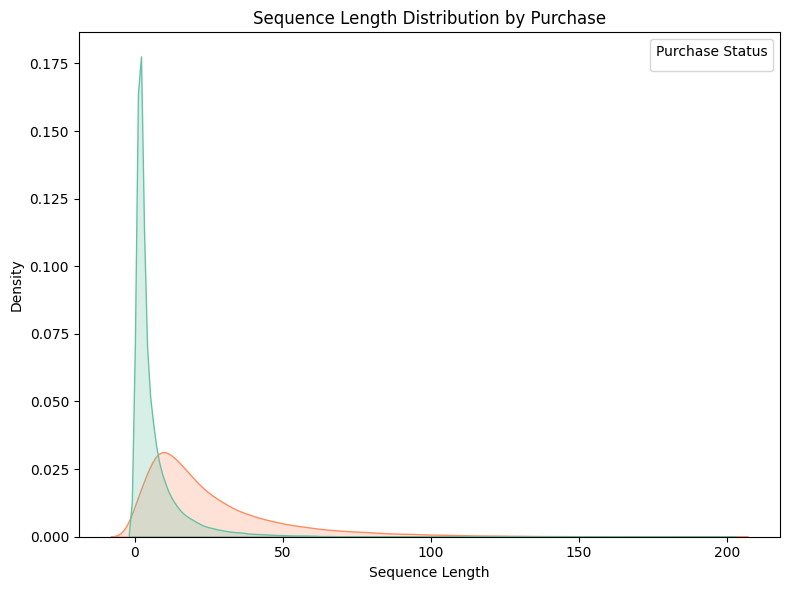

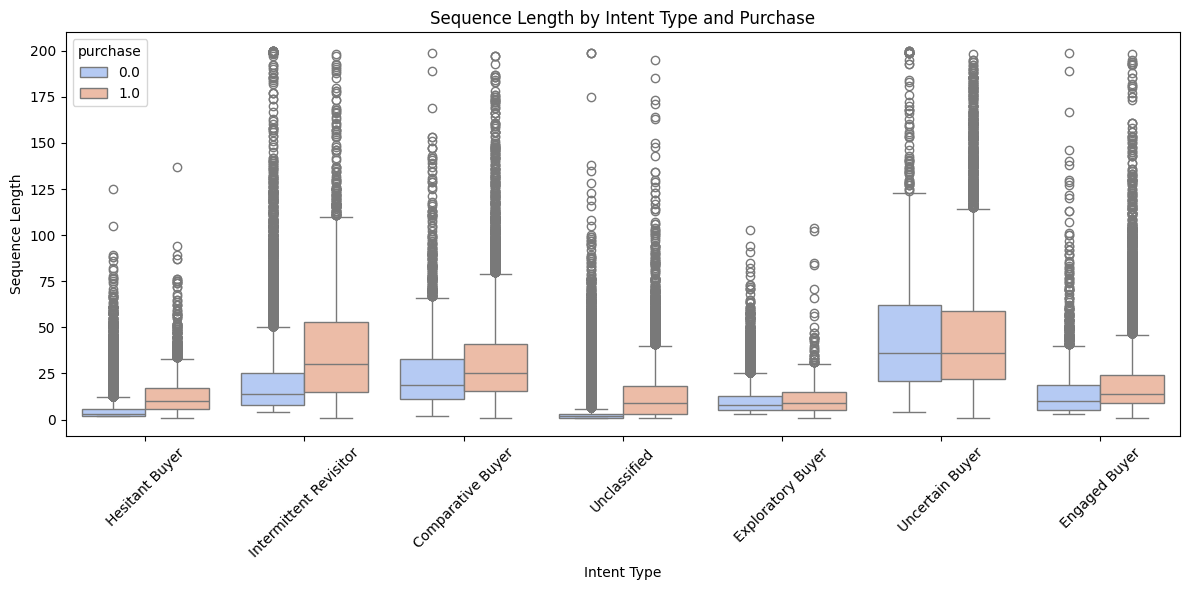

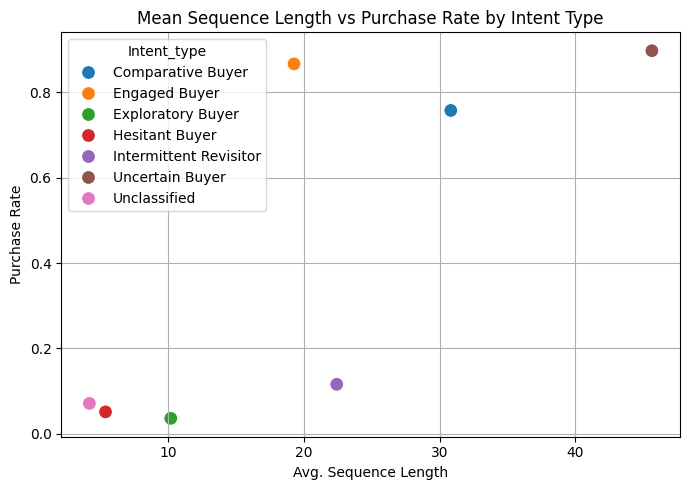

In [9]:
import pandas as pd
import ast
import seaborn as sns
import matplotlib.pyplot as plt

# 讀入資料
df = pd.read_csv("results2.csv")  # ← 請換成你的檔案路徑
df["truncated_sequence"] = df["truncated_sequence"].apply(ast.literal_eval)
df["sequence_length"] = df["truncated_sequence"].apply(len)

# 若 Intent_type 欄位尚未有，請根據你的資料產生




import seaborn as sns
import matplotlib.pyplot as plt

# 先轉換 purchase 成文字標籤
df["purchase_label"] = df["purchase"].map({0: "No Purchase", 1: "Purchase"})

# 畫 KDE plot，用文字標籤當作 hue
plt.figure(figsize=(8, 6))
sns.kdeplot(
    data=df,
    x="sequence_length",
    hue="purchase_label",
    fill=True,
    common_norm=False,
    palette="Set2"
)

plt.title("Sequence Length Distribution by Purchase")
plt.xlabel("Sequence Length")
plt.ylabel("Density")
plt.legend(title="Purchase Status")
plt.tight_layout()
plt.show()


# 各 Intent 類型中，不同購買行為的序列長度分布
plt.figure(figsize=(12, 6))
sns.boxplot(data=df, x="Intent_type", y="sequence_length", hue="purchase", palette="coolwarm")
plt.title("Sequence Length by Intent Type and Purchase")
plt.xlabel("Intent Type")
plt.ylabel("Sequence Length")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# 額外（選配）：平均長度 vs 購買率 scatter
intent_stats = df.groupby("Intent_type").agg({
    "sequence_length": "mean",
    "purchase": "mean"
}).reset_index()

plt.figure(figsize=(7, 5))
sns.scatterplot(data=intent_stats, x="sequence_length", y="purchase", hue="Intent_type", s=100)
plt.title("Mean Sequence Length vs Purchase Rate by Intent Type")
plt.xlabel("Avg. Sequence Length")
plt.ylabel("Purchase Rate")
plt.grid(True)
plt.tight_layout()
plt.show()


<ipython-input-5-8acc7348de10>:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(data=intent_summary, x="Intent_type", y="purchase_rate", palette="viridis")


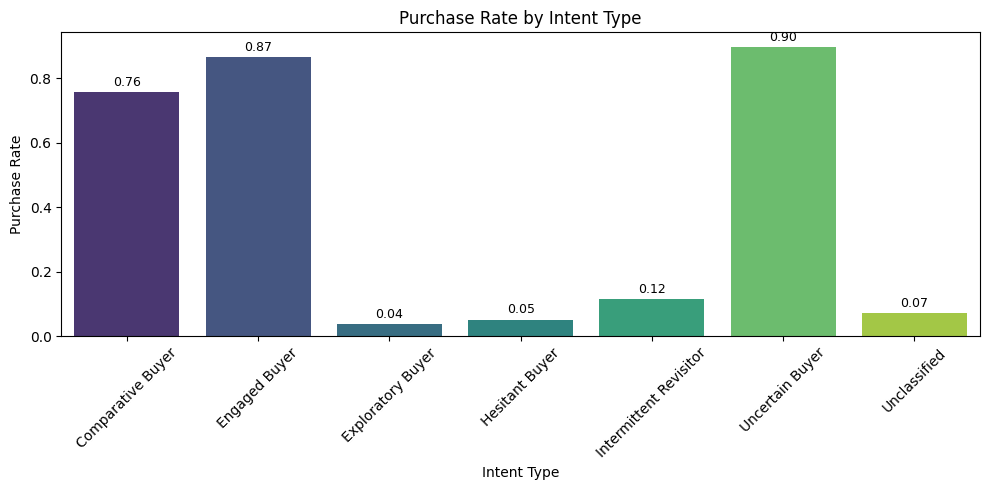

In [5]:
import seaborn as sns
import matplotlib.pyplot as plt

# 建立 intent_summary（如果你還沒有）
intent_purchase_rate = df.groupby("Intent_type")["purchase"].agg(["count", "sum", "mean"]).reset_index()
intent_purchase_rate.rename(columns={"mean": "purchase_rate", "sum": "purchase_count"}, inplace=True)
intent_seq_length = df.groupby("Intent_type")["sequence_length"].agg(["mean", "median", "max", "min"]).reset_index()
intent_summary = pd.merge(intent_purchase_rate, intent_seq_length, on="Intent_type")

# 畫圖
plt.figure(figsize=(10, 5))
ax = sns.barplot(data=intent_summary, x="Intent_type", y="purchase_rate", palette="viridis")

# 加上數字標籤（在每個 bar 上方）
for i, bar in enumerate(ax.patches):
    height = bar.get_height()
    ax.text(
        bar.get_x() + bar.get_width() / 2,
        height + 0.01,  # 讓文字稍微高於 bar
        f'{height:.2f}',  # 顯示小數點後2位
        ha='center', va='bottom', fontsize=9
    )

# 標題與標籤
plt.title("Purchase Rate by Intent Type")
plt.ylabel("Purchase Rate")
plt.xlabel("Intent Type")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


<ipython-input-10-c06ad759f33f>:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(data=intent_summary, x="Intent_type", y="mean", palette="magma")


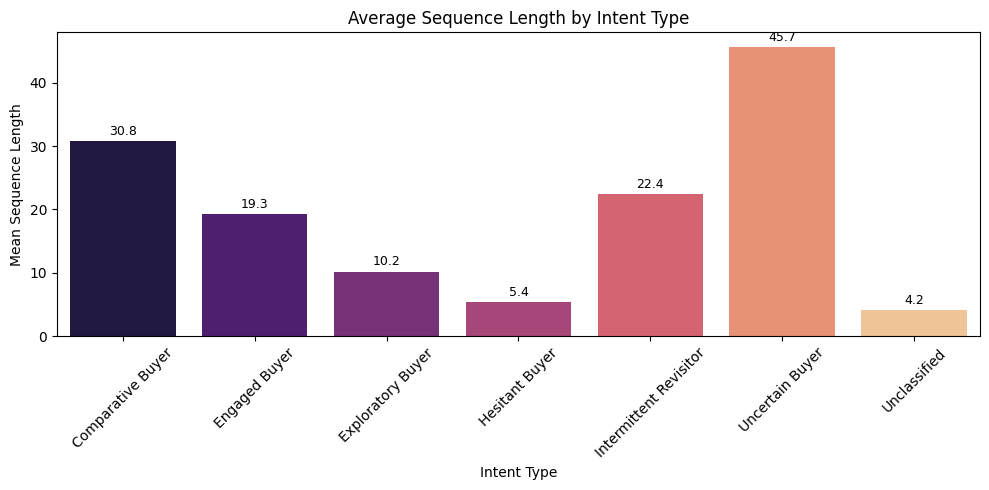

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 5))

# 先繪製 barplot 並取得 ax 物件
ax = sns.barplot(data=intent_summary, x="Intent_type", y="mean", palette="magma")

# 加上每個柱狀圖上方的數字標籤
for bar in ax.patches:
    height = bar.get_height()
    ax.text(
        bar.get_x() + bar.get_width() / 2,
        height + 0.5,  # 可以視數值大小調整間距
        f'{height:.1f}',  # 顯示小數點後1位
        ha='center', va='bottom', fontsize=9
    )

# 加上標題與軸標籤
plt.title("Average Sequence Length by Intent Type")
plt.ylabel("Mean Sequence Length")
plt.xlabel("Intent Type")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [1]:
# ✨ G1: Sequence + Cluster Label Input

import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models, Input
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import ast

# --- Load & preprocess data ---
df = pd.read_csv("results2_with_cluster (1).csv")
df["truncated_sequence"] = df["truncated_sequence"].apply(ast.literal_eval)
df["X_seq"] = df["truncated_sequence"].apply(lambda x: (x + [0]*30)[:30])
df["cluster"] = df["cluster"].fillna(-1).astype(int)

X_seq = np.array(df["X_seq"].tolist())
X_cluster = tf.keras.utils.to_categorical(df["cluster"].values)
y = df["purchase"].values

X_seq_tr, X_seq_te, X_cluster_tr, X_cluster_te, y_tr, y_te = train_test_split(
    X_seq, X_cluster, y, test_size=0.2, random_state=42
)

# --- MC Dropout Layer ---
class MCDropout(tf.keras.layers.Dropout):
    def call(self, inputs, training=None):
        return super().call(inputs, training=True)

# --- Transformer Block ---
def transformer_block(x, embed_dim, num_heads, ff_dim, dropout):
    attn_output = layers.MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)(x, x)
    attn_output = MCDropout(dropout)(attn_output)
    out1 = layers.LayerNormalization()(x + attn_output)
    ffn_output = layers.Dense(ff_dim, activation="relu")(out1)
    ffn_output = layers.Dense(embed_dim)(ffn_output)
    ffn_output = MCDropout(dropout)(ffn_output)
    return layers.LayerNormalization()(out1 + ffn_output)

# --- Build G1 Model ---
def create_model_g1():
    MAXLEN, VOCAB_SIZE, EMBED_DIM, FF_DIM, NUM_HEADS, DROPOUT = 30, 6, 32, 64, 2, 0.3

    seq_input = Input(shape=(MAXLEN,), name='sequence_input')
    cluster_input = Input(shape=(X_cluster.shape[1],), name='cluster_input')

    x = layers.Embedding(VOCAB_SIZE, EMBED_DIM, mask_zero=True)(seq_input)
    pos_encoding = layers.Embedding(MAXLEN, EMBED_DIM)(tf.range(MAXLEN))
    x = x + pos_encoding
    x = transformer_block(x, EMBED_DIM, NUM_HEADS, FF_DIM, DROPOUT)
    x = layers.GlobalAveragePooling1D()(x)

    cluster_proj = layers.Dense(EMBED_DIM, activation='relu')(cluster_input)

    x = layers.Concatenate()([x, cluster_proj])
    x = layers.Dense(FF_DIM, activation='relu')(x)
    x = MCDropout(DROPOUT)(x)
    output = layers.Dense(1, activation='sigmoid')(x)

    model = models.Model(inputs=[seq_input, cluster_input], outputs=output)
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

# --- Monte Carlo Dropout Prediction ---
def mc_predict(model, X_input, T=10):
    preds = np.stack([model.predict(X_input, verbose=0).squeeze() for _ in range(T)], axis=0)
    return preds.mean(axis=0), preds.std(axis=0)

# --- Save Results ---
def save_mc_predictions(y_prob, y_std, y_true, filename):
    df_out = pd.DataFrame({
        "y_true": y_true,
        "y_prob": y_prob,
        "uncertainty_std": y_std
    })
    df_out.to_csv(filename, index=False)
    print(f"Saved to {filename}")

# --- Train & Evaluate ---
def train_eval(model, X_train, y_train, X_test, y_test, name, T=10):
    cb = tf.keras.callbacks.EarlyStopping(patience=3, restore_best_weights=True)
    model.fit(X_train, y_train, epochs=10, batch_size=32,
              validation_data=(X_test, y_test), callbacks=[cb])
    y_prob, y_std = mc_predict(model, X_test, T)
    y_pred = (y_prob > 0.5).astype(int)
    print(f"\n{name} Evaluation:")
    print("Accuracy :", accuracy_score(y_test, y_pred))
    print("Precision:", precision_score(y_test, y_pred, zero_division=0))
    print("Recall   :", recall_score(y_test, y_pred))
    print("F1 Score :", f1_score(y_test, y_pred))
    print("Mean Uncertainty:", y_std.mean())
    save_mc_predictions(y_prob, y_std, y_test, f"{name}_mc.csv")

# --- Run G1 ---
model_g1 = create_model_g1()
train_eval(model_g1,
           {"sequence_input": X_seq_tr, "cluster_input": X_cluster_tr},
           y_tr,
           {"sequence_input": X_seq_te, "cluster_input": X_cluster_te},
           y_te, "G1")


Epoch 1/10
693/693 ━━━━━━━━━━━━━━━━━━━━ 24s 25ms/step - accuracy: 0.8628 - loss: 0.3155 - val_accuracy: 0.9413 - val_loss: 0.1823
Epoch 2/10
693/693 ━━━━━━━━━━━━━━━━━━━━ 16s 19ms/step - accuracy: 0.9349 - loss: 0.1918 - val_accuracy: 0.9368 - val_loss: 0.1847
Epoch 3/10
693/693 ━━━━━━━━━━━━━━━━━━━━ 21s 20ms/step - accuracy: 0.9365 - loss: 0.1861 - val_accuracy: 0.9411 - val_loss: 0.1748
Epoch 4/10
693/693 ━━━━━━━━━━━━━━━━━━━━ 20s 19ms/step - accuracy: 0.9363 - loss: 0.1869 - val_accuracy: 0.9411 - val_loss: 0.1771
Epoch 5/10
693/693 ━━━━━━━━━━━━━━━━━━━━ 13s 19ms/step - accuracy: 0.9383 - loss: 0.1792 - val_accuracy: 0.9411 - val_loss: 0.1746
Epoch 6/10
693/693 ━━━━━━━━━━━━━━━━━━━━ 20s 19ms/step - accuracy: 0.9336 - loss: 0.1907 - val_accuracy: 0.9419 - val_loss: 0.1730
Epoch 7/10
693/693 ━━━━━━━━━━━━━━━━━━━━ 20s 18ms/step - accuracy: 0.9372 - loss: 0.1817 - val_accuracy: 0.9406 - val_loss: 0.1731
Epoch 8/10
693/693 ━━━━━━━━━━━━━━━━━━━━ 21s 19ms/step - accuracy: 0.9355 - loss: 0.1841 - 

In [ ]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models, Input
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import ast

# Load and preprocess
df = pd.read_csv("results2_with_cluster (1).csv")
df['truncated_sequence'] = df['truncated_sequence'].apply(ast.literal_eval)
df['X_seq'] = df['truncated_sequence'].apply(lambda x: (x + [0]*30)[:30])
df['cluster'] = df['cluster'].fillna(-1).astype(int)

X_seq = np.array(df['X_seq'].tolist())
X_cluster = tf.keras.utils.to_categorical(df['cluster'].values)
y = df['purchase'].values

X_seq_tr, X_seq_te, X_cluster_tr, X_cluster_te, y_tr, y_te = train_test_split(
    X_seq, X_cluster, y, test_size=0.2, random_state=42
)

# MC Dropout Layer
class MCDropout(tf.keras.layers.Dropout):
    def call(self, inputs, training=None):
        return super().call(inputs, training=True)

# Build LSTM model for G1 (sequence + cluster)
def create_lstm_mc_model_g1():
    MAXLEN = 30
    VOCAB_SIZE = 6
    EMBED_DIM = 32
    LSTM_UNITS = 64
    FF_DIM = 64
    DROPOUT = 0.3

    # Inputs
    seq_input = Input(shape=(MAXLEN,), name='sequence_input')
    cluster_input = Input(shape=(X_cluster.shape[1],), name='cluster_input')

    # Sequence branch
    x = layers.Embedding(VOCAB_SIZE, EMBED_DIM, mask_zero=True)(seq_input)
    x = layers.LSTM(LSTM_UNITS)(x)
    x = MCDropout(DROPOUT)(x)

    # Cluster branch
    cluster_proj = layers.Dense(EMBED_DIM, activation='relu')(cluster_input)

    # Combine
    x = layers.Concatenate()([x, cluster_proj])
    x = layers.Dense(FF_DIM, activation='relu')(x)
    x = MCDropout(DROPOUT)(x)
    output = layers.Dense(1, activation='sigmoid')(x)

    model = models.Model(inputs=[seq_input, cluster_input], outputs=output)
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

# MC Dropout prediction
def mc_predict(model, X_input, T=10):
    preds = np.stack([model.predict(X_input, verbose=0).squeeze() for _ in range(T)], axis=0)
    return preds.mean(axis=0), preds.std(axis=0)

# Save prediction result
def save_mc_predictions(y_prob, y_std, y_true, filename):
    df_out = pd.DataFrame({
        "y_true": y_true,
        "y_prob": y_prob,
        "uncertainty_std": y_std
    })
    df_out.to_csv(filename, index=False)
    print(f"📁 Saved: {filename}")

# Train and evaluate
def train_eval(model, X_train, y_train, X_test, y_test, name, T=10):
    print(f"\n🚀 Training {name}...")
    cb = tf.keras.callbacks.EarlyStopping(patience=3, restore_best_weights=True)

    model.fit(X_train, y_train, epochs=10, batch_size=32,
              validation_data=(X_test, y_test), callbacks=[cb], verbose=1)

    print(f"🔎 Predicting with MC Dropout (T={T})...")
    y_prob, y_std = mc_predict(model, X_test, T)
    y_pred = (y_prob > 0.5).astype(int)

    print(f"\n📊 {name} Evaluation:")
    print("Accuracy :", accuracy_score(y_test, y_pred))
    print("Precision:", precision_score(y_test, y_pred, zero_division=0))
    print("Recall   :", recall_score(y_test, y_pred))
    print("F1 Score :", f1_score(y_test, y_pred))
    print("Mean Uncertainty:", y_std.mean())

    save_mc_predictions(y_prob, y_std, y_test, f"{name}_mc.csv")
    model.save(f"{name}.h5")
    print(f"✅ Model saved as {name}.h5")

# Run G1
train_eval(create_lstm_mc_model_g1(),
           {"sequence_input": X_seq_tr, "cluster_input": X_cluster_tr}, y_tr,
           {"sequence_input": X_seq_te, "cluster_input": X_cluster_te}, y_te, "G1_LSTM")
